# Preliminary Models

This notebook explores the data set and investigates a wide range of models using vectorizing words to prepare our text.

## Imports and Functions

In [ ]:
import pickle

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# prep for models and search parameter space
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# selection of features
from sklearn.decomposition import PCA

# models
from sklearn.linear_model import LogisticRegression

# model evaluation
from sklearn.metrics import (
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, 
    classification_report, 
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)


# stopwords
import nltk
import spacy
from gensim.parsing.preprocessing import STOPWORDS

### Evaluate Models

In [127]:
def evaluate_model(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                   short_name='short', return_misclassified=False, return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = "Model details here"
        string to form the subtitle of figures
    short_name : str, default = "short"
        string used name saved figures and scoring dictionary
    return_misclassified : bool, default = False
        returns Data Frame of misclassified results when True: true value, predicted value, probability calculated by model
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res : pandas Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for misclassified results, only returned if `return_misclassified == True`
    res_all : panda Data Frame, optional
        contains the true values, predicted values, and calculated probabilities for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)

    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }
    
    # misclassified results
    results = []
    for i in range(len(y_test)):
        if preds[i] != y_test.iloc[i]:
            results.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})

    res = pd.DataFrame(results)

    # probability histogram of misclassified results
    fig_hist = px.histogram(
        res, 
        x='prob_fraud', 
        title = 'Probability Distribution of Misclassified Job Ads', 
        subtitle= f'Model: {fig_subtitle}'
    )

    fig_hist.show()


    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i], 'prob_fraud': proba[i][1]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');

    # save figures, if save_figs is True
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_hist.write_image(f'../images/hist_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    # return options
    if return_all_results == True and return_misclassified == True:
        return scores, res, res_all
    elif return_all_results == True:
        return scores, res_all
    elif return_misclassified == True:
        return scores, res
    else:
        return scores

In [128]:
def evaluate_model_noprob(model, X_test, y_test, save_figs = False, fig_subtitle = 'Model details here', 
                          short_name='short', return_all_results=False):
    '''
    For models that predict probability of classification: evaluates model, creates useful figures, and returns metric scores and data frame of misclassified results

    Parameters
    ----------
    model : object that contains the model

    X_test : array-like of shape (n_samples, n_features)
        the features in the test data
    y_test : array-like of shape (n_samples,)
        the true classification of the test data
    save_figs : bool, default = False
        tells function to save figures created or not
    fig_subtitle : str, default = 'Model details here'
        string to form the subtitle of figures
    short_name : str, default = 'short'
        string used name saved figures
    return_all_results : bool, default = False
        returns Data Frame of all results when True: true value, predicted value, probability calculated by model

    Returns
    -------
    scores : dict
        dictionary containing model short_name and calculated accuracy, precision, recall, f1-score, and roc-auc-score
    res_all : panda Data Frame, optional
        contains the true and predicted values for all results, only returned if `return_all_results == True`
    '''
    preds = model.predict(X_test)
    
    # confusion matrix
    fig_cm, ax_cm = plt.subplots()
    
    ConfusionMatrixDisplay.from_predictions(y_test, preds, display_labels=['real','fraudulent'], ax=ax_cm)
    ax_cm.set_title(f'Confusion Matrix: {fig_subtitle}');
    
    fig_cm.show()
    
    # classification report
    print(f"\nClassification Report: \n")
    print(classification_report(y_test, preds, target_names=['real', 'fraudulent']))

    # metrics: accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    scores = {
        'model': short_name,
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1_score': f1_score(y_test, preds),
        'roc_auc_score': roc_auc_score(y_test, preds),
    }

    # all results
    if return_all_results == True:
        results_all = []
        for i in range(len(y_test)):
            results_all.append({'actual': y_test.iloc[i], 'predicted': preds[i]})
        
        res_all = pd.DataFrame(results_all)

    # precision-recall and roc curves
    fig_curves, axes = plt.subplots(1, 2, figsize=(12,6))

    fig_curves.suptitle(f'Model: {fig_subtitle}', fontsize=18)

    ax=axes[0]
    PrecisionRecallDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

    ax=axes[1]
    RocCurveDisplay.from_predictions(y_test, preds, ax=ax)
    ax.set_title('ROC curve')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate');
    
    if save_figs == True:
        fig_cm.savefig(f'../images/cm_{short_name}.png')
        fig_curves.savefig(f'../images/curves_{short_name}.png')

    if return_all_results == True:
        return scores, res_all
    else:
        return scores

In [129]:
def save_model (model, filename):
    '''
    pickles model as filename.pkl in the models directory
    '''
    with open(f'./models/{filename}.pkl', 'wb') as f:
        pickle.dump(model, f)

### Stopwords

In [161]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erindepree/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [354]:
# nltk stopwords
stopwords_nltk = list(nltk.corpus.stopwords.words('english'))

# spacy stopwords
nlp = spacy.load("en_core_web_sm")
stopwords_spacy = list(nlp.Defaults.stop_words)

# gensim stopwords
stopwords_gensim = list(STOPWORDS)

In [355]:
def determine_stopword_list(stopwords):
    """
    takes a list (or anything that be forced into a set) and compares it with our other stopwords lists to determine which list it is

    Parameters
    ----------
    stopwords : list (or set / anything that can be forced into a set) of strings
        list of stopwords used in model

    Returns
    -------
    list_name : string
        name of likely list
    """
    
    if len(set(stopwords).difference(set(stopwords_gensim))) == 0:
        list_name = 'Gensim'
    elif len(set(ridge.best_params_['ct__cv__stop_words']).difference(set(stopwords_spacy))) == 0:
        list_name = 'spaCy'
    elif len(set(ridge.best_params_['ct__cv__stop_words']).difference(set(stopwords_nltk))) == 0:
        list_name = 'NLTK'
    else:
        list_name = 'not Gensim, spaCy, or NLTK default lists'

    return list_name

### Functions to Style Tables

In [130]:
def highlight_max(s, props=''):
    return np.where(s == np.max(s.values), props, '')

In [131]:
def highlight_min(s, props=''):
    return np.where(s == np.min(s.values), props, '')

## Data

### Data Import

In [132]:
df = pd.read_csv('../data/clean/job_ads.csv')

In [133]:
df.head()

telecommuting  has_company_logo  has_questions employment_type  \
0              0                 1              0           Other   
1              0                 1              0       Full-time   
2              0                 1              0             NaN   
3              0                 1              0       Full-time   
4              0                 1              1       Full-time   

  required_experience  fraudulent  \
0          Internship           0   
1      Not Applicable           0   
2                 NaN           0   
3    Mid-Senior level           0   
4    Mid-Senior level           0   

                                              job_ad  
0  We're Food52, and we've created a groundbreaki...  
1  90 Seconds, the worlds Cloud Video Production ...  
2  Valor Services provides Workforce Solutions th...  
3  Our passion for improving quality of life thro...  
4  SpotSource Solutions LLC is a Global Human Cap...

### Set Up Data

In [134]:
X = df.drop(columns=['fraudulent'])
y = df['fraudulent']

In [135]:
X = X.fillna('')

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=1613)

In [137]:
X_train.columns

Index(['telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'job_ad'],
      dtype='object')

In [138]:
type(X_test)

pandas.core.frame.DataFrame

In [139]:
X_test.shape

(4470, 6)

## Base Model

The simplest model is to simply guess that all of the job ads are non-fraudulent.

In [140]:
target = px.histogram(
    df['fraudulent'], 
    category_orders={0:'real', 1:'fraud'}, 
    title='Class Distribution',
    subtitle='Real job ads (labeled 0) and fraudulent job ads (labeled 1)'
)
target.show()

target.write_image(f'../images/target_distribution.png')

In [141]:
df['fraudulent'].value_counts(normalize=True)

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64

This gives us a base model accuracy of 0.95157.  

In [142]:
y_test.sum()

216

In [143]:
len(y_test)

4470

In [144]:
base_preds = []

for i in range(len(y_test)):
    base_preds.append(0)

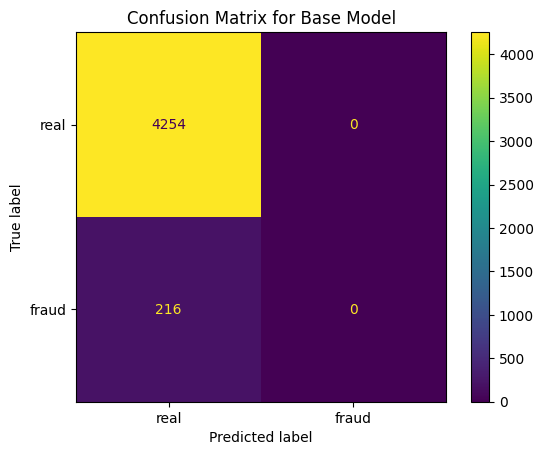

In [145]:
cm = ConfusionMatrixDisplay.from_predictions(y_test, base_preds, display_labels=['real', 'fraud']);

_ = cm.ax_.set_title('Confusion Matrix for Base Model')
cm.figure_.savefig(f'../images/cm_baseline.png')

In [146]:
print(classification_report(y_test, base_preds, target_names=['real', 'fraud'], zero_division=0))

              precision    recall  f1-score   support

        real       0.95      1.00      0.98      4254
       fraud       0.00      0.00      0.00       216

    accuracy                           0.95      4470
   macro avg       0.48      0.50      0.49      4470
weighted avg       0.91      0.95      0.93      4470



In [147]:
scores_base = {
    'model': 'base',
    'accuracy': accuracy_score(y_test, base_preds),
    'precision': precision_score(y_test, base_preds, zero_division=0),
    'recall': recall_score(y_test, base_preds),
    'f1_score': f1_score(y_test, base_preds),
    'roc_auc_score': roc_auc_score(y_test, base_preds)
}

scores_base

{'model': 'base',
 'accuracy': 0.9516778523489933,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'roc_auc_score': 0.5}

Although the base model has an over all accuracy of 0.95168, the other metrics are terrible: precision, recall, and the F1-score are all 0.  With an roc-auc score of 0.5.

__Accuracy__ tells us how many of the job ads were correctly classified.  Since the majority of the job ads are real, this dominates our result.  

__Precision__, also known as the positive predictive value, tells us how many of the ads that we classified as fraudulent are actually fraudulent.  (Since we guessed they were all real, this is actually being divided by zero, I've made the executive decision to set this equal to zero.)

__Recall__, or sensitivity or the true positive rate (TPR), tells us how many of the fraudulent job ads we properly identified with our model.  In this case we identified no fraudulent ads and, thus, caught none of them!

__F1-score__ is a metric designed to balance both precision and recall.  The F1-score is the _harmonic mean_ of precision and recall.  We usually use the _arithmetic mean_, for two values, $a$ and $b$, the arithmetic mean is

$$ \text{arithmetic mean} = \frac{a + b}{2} $$

The harmonic mean is actually the reciprocal of the arithmetic mean of the reciprocals of the numbers:

$$ \text{harmonic mean} = \frac{1}{ \frac{1/a + 1/b}{2} } = \frac{2}{\frac{1}{a} + \frac{1}{b}} = \frac{2 a b}{a+b}$$

These different types of means (and there are others which we will not discuss) are useful in when handling different types of data.  The harmonic mean is best used when handling rates or ratios (like we are).

So the F1-score is calculated from the precision and recall:

$$ \text{F1-score} = \frac{2 \left(\text{precision}\right) \left(\text{recall}\right) }{\text{precision} + \text{recall} } $$

Our final score is the __ROC AUC score__ stands for Receiver Operator Characteristic Area Under the Curve Score.  The Receiver Operator Characteristic curve is a plot of the recall (or true positive rate) as a function of the false positive rate (FPR).  The false positive rate is also sometimes referred to as a type I error.  We simply calculate the area under the curve to compute the ROC AUC score.  

Actually, it turns out that guess will always lead to an ROC AUC score of 0.5.  So, our model needs to do better than this.

The true positive rate and false positive rate are not fixed, especially for models which calculate the probability of an entry being in a class.  We could make the decision at 50% or 80% or any other number.  By varying this threshold, we get the ROC curve.  Here's a lovely graphic from the [evidentlyAI website](https://www.evidentlyai.com/classification-metrics/explain-roc-curve) showing ROC curves for a perfect model, an OK model, and random guessing:

![](https://cdn.prod.website-files.com/660ef16a9e0687d9cc27474a/662c42679571ef35419c9935_647607123e84a06a426ce627_classification_metrics_014-min.png)
Image credit: [evidentlyAI](https://www.evidentlyai.com/classification-metrics/explain-roc-curve)

We will use all of these metrics to assess our models.

## Logistic Regression Models

We begin with logistic regression.  This has the advantage of being a linear model (and thus has interpretable coefficients) as well as being a fairly fast model to fit.  

We need to somehow convert our text into numbers, so the computer can work with it.  We will start with vectorization.  Specifically we will use the Bag of Words model.  The general strategy is to (1) tokenize the words (create a column for each word used), (2) count how many times each word or token occurs, and (3) normalize the results.  This bascially what the `CountVectorizer` does for us.

However there are many, many words that appear often but don't actually contribute much to the overall meaning of the text (e.g. a, the, is).  I like to think of these are grammatical aids but not, necessarily, helpful classifying tokens. Tf-idf mean term frequency times inverse document frequency.

$$ \text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t) $$

where $t$ is the term (a token) and $d$ is a document (or sample or, in our case, a single ad).  The term frequency, tf, is the number of times a term appears in an ad, or 'document'.  The inverse document frequency, idf, is given by 

$$ \text{idf}(t) = \log_e \frac{1+n}{1+ \text{df}(t)} + 1 $$

where $n$ is total number of documents (or ads, in this case) and $df(t)$ is the number of documents (or ads) containing the term $t$.  Then we normalize the tf-idf result and work with that.  

This works well until we remember that each word (or token) often has more than one meaning.  Which meaning is being referred to here?  This leads to embeddings, which I will look at in another [notebook]('embedding_models.ipynb').

### Basic Logistic Regression, no penalty, with CountVectorizer

In [148]:
model_log = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [149]:
model_log.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.89      0.79      0.84       216

    accuracy                           0.99      4470
   macro avg       0.94      0.89      0.92      4470
weighted avg       0.98      0.99      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



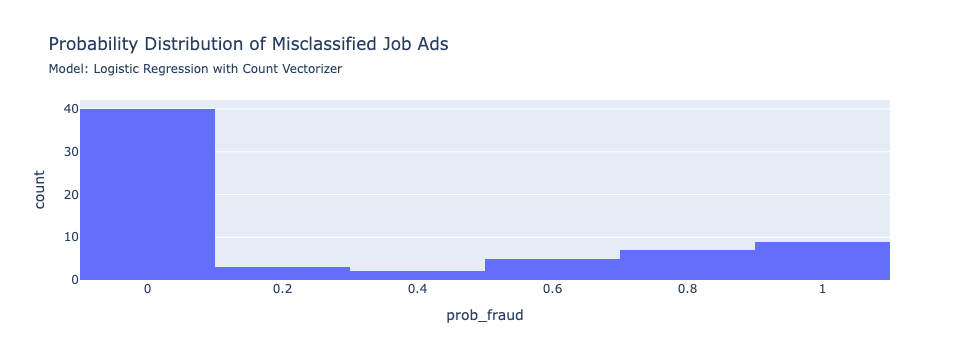

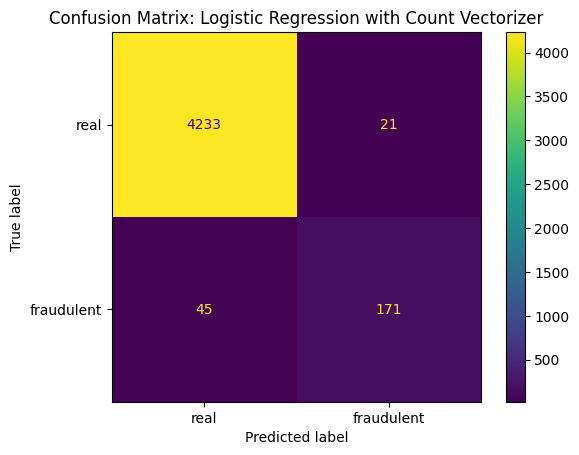

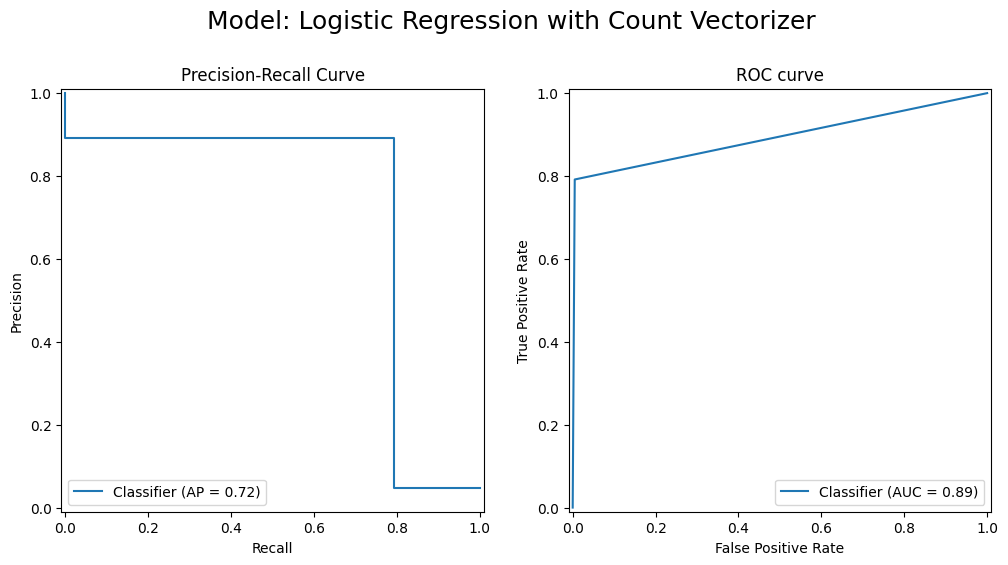

In [414]:
scores_log_cv, res_log_cv = evaluate_model(
    model_log, 
    X_test, 
    y_test, 
    fig_subtitle= 'Logistic Regression with Count Vectorizer', 
    short_name='log_cv', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [415]:
save_model(model_log, 'model_log_cv')

In [152]:
res_log_cv.to_csv('../data/results/res_log_cv.csv')

In [153]:
scores_log_cv

{'model': 'log_cv',
 'accuracy': 0.9852348993288591,
 'precision': 0.890625,
 'recall': 0.7916666666666666,
 'f1_score': 0.8382352941176471,
 'roc_auc_score': 0.8933650681711329}

### Logistic Regression with TF-IDF Vectorizer

In [154]:
model_log_tfidf = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None))
])

In [155]:
model_log_tfidf.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.85      0.79      0.82       216

    accuracy                           0.98      4470
   macro avg       0.92      0.89      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



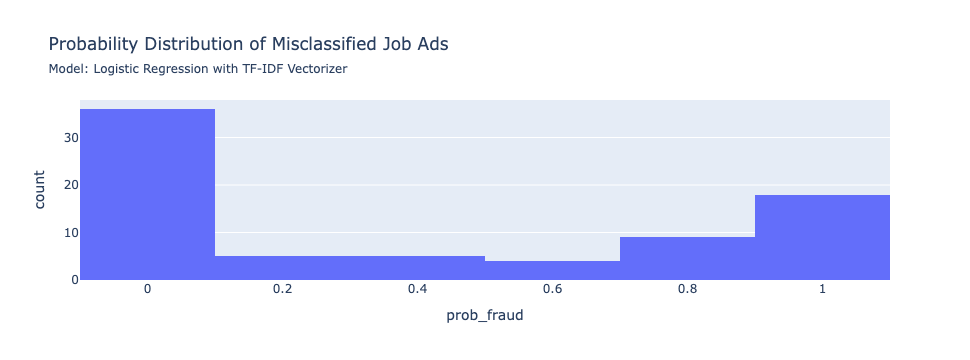

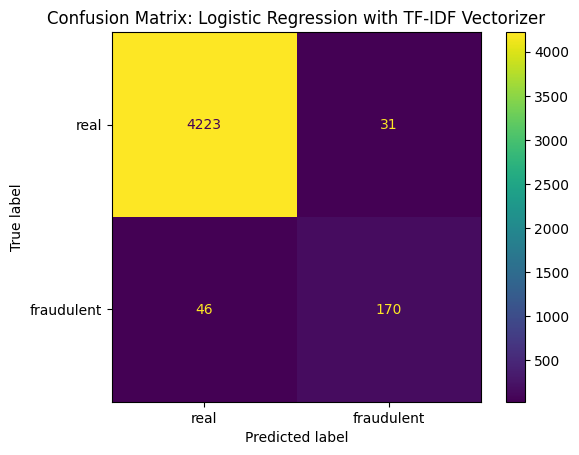

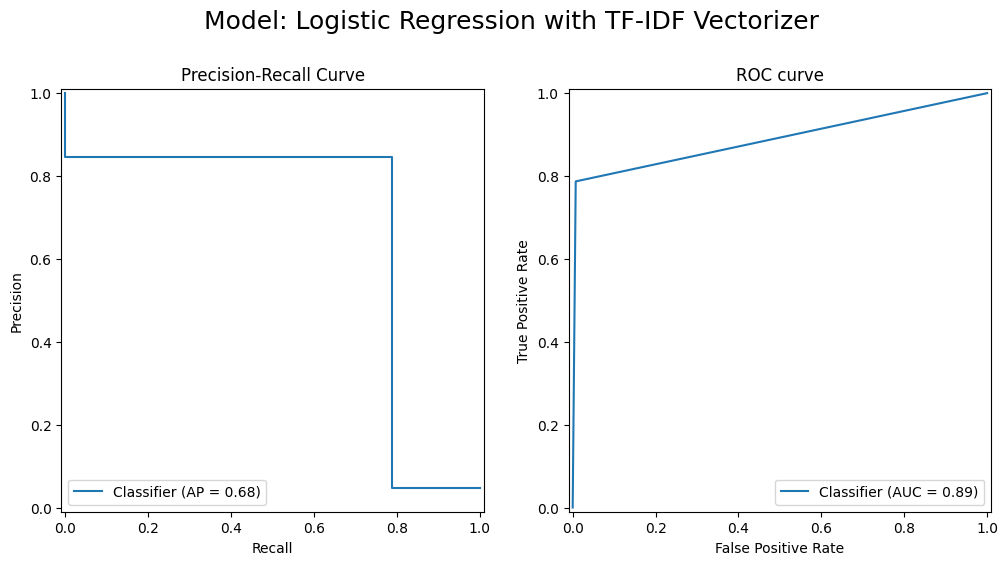

In [315]:
scores_log_tfidf, res_log_tfidf = evaluate_model(
    model_log_tfidf, 
    X_test, 
    y_test, 
    fig_subtitle= 'Logistic Regression with TF-IDF Vectorizer', 
    short_name='log_tfidf', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [157]:
save_model(model_log_tfidf, 'model_tfidf_log')

In [158]:
res_log_tfidf.to_csv('../data/results/res_log_tfidf.csv')

In [159]:
scores_log_tfidf

{'model': 'log_tfidf',
 'accuracy': 0.9827740492170023,
 'precision': 0.845771144278607,
 'recall': 0.7870370370370371,
 'f1_score': 0.815347721822542,
 'roc_auc_score': 0.8898748889933658}

### Preprocess Comparision

In [160]:
pd.DataFrame([scores_base, scores_log_cv, scores_log_tfidf]).style.apply(
    highlight_max, props='color:white; background-color:darkblue', axis=0, 
    subset=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
)

### Stop Words

Stop words are words that we do not want to include in our analysis as they are not helpful, e.g. "the", "will", etc.  These are words that are used frequently but are not helpful in the analysis.  There are problems with stop word lists, mostly because people use them without considering the implications or where the lists came from.  [Stop Word Lists in Free Open-source Software Packages](https://aclanthology.org/W18-2502/) (Nothman et al., NLPOSS 2018) explained the problems with many lists of stop words: not knowing where the list came from, not all forms of a word being included or excluded from the list, inclusion of "controversial" words (words appearing in less than 10% of the commonly used lists), and typos, to name a few.  

Thus, I have decided to investigate a few stop word lists in this section to see how they impact my model.

At the top of file, I imported three additional stopwords lists: 
1. `stopwords_nltk` from [Natural Language Tool Kit](https://www.nltk.org/howto/portuguese_en.html#stopwords),
2. `stopwords_spacy` from [spaCy](https://spacy.io/usage/linguistic-features#section-language-data), and
3. `stopwords_gensim` from [Gensim](https://radimrehurek.com/gensim/parsing/preprocessing.html).

This is in addition to the built-in SciKit-Learn list (which I will refer to as `stopwords_sklearn` when needed, however it is included with the option 'english' in the vectorizer function).

#### CV with SciKit-Learn Default Stopwords

In [166]:
model_log_stop_sklearn = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2), stop_words= 'english'), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [167]:
model_log_stop_sklearn.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.91      0.79      0.85       216

    accuracy                           0.99      4470
   macro avg       0.95      0.89      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



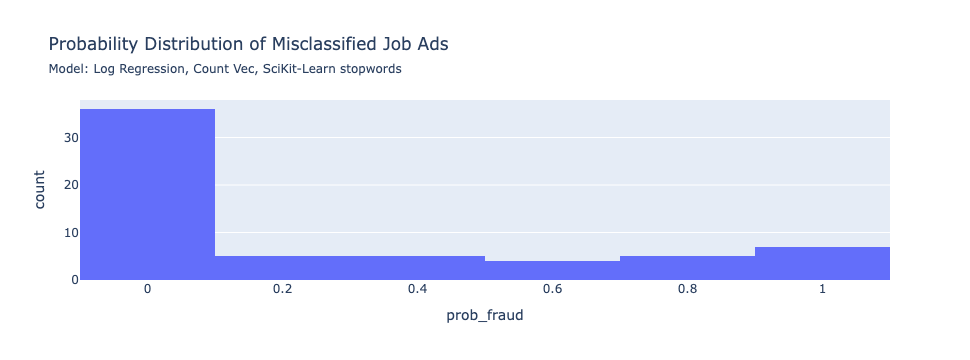

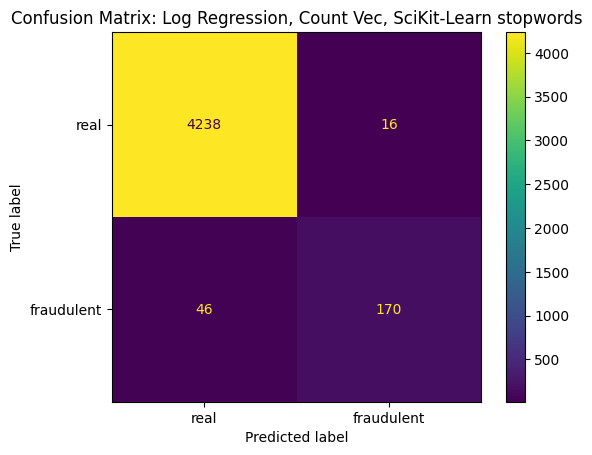

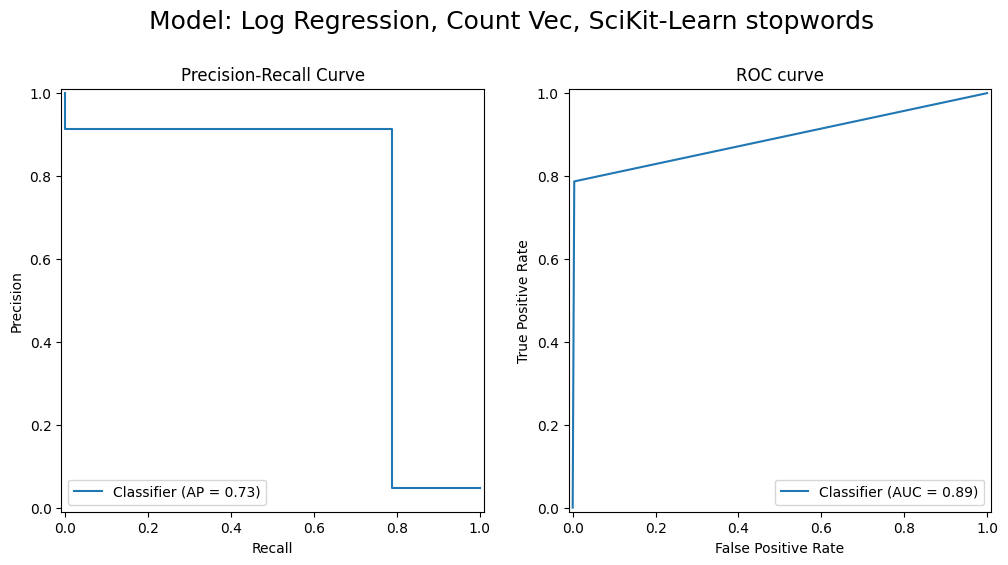

In [387]:
scores_log_cv_stop_sklearn, res_log_cv_stop_sklearn = evaluate_model(
    model_log_stop_sklearn, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, SciKit-Learn stopwords', 
    short_name='log_cv_stop_sklearn', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [169]:
save_model(model_log_stop_sklearn, 'model_log_cv_stop_sklearn')

In [170]:
res_log_cv_stop_sklearn.to_csv('../data/results/res_log_cv_stop_sklearn.csv')

In [171]:
scores_log_cv_stop_sklearn

{'model': 'log_cv_stop_sklearn',
 'accuracy': 0.9861297539149888,
 'precision': 0.9139784946236559,
 'recall': 0.7870370370370371,
 'f1_score': 0.845771144278607,
 'roc_auc_score': 0.8916379355377946}

#### CV with NLTK Stopwords

In [172]:
model_log_stop_nltk = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2), stop_words= stopwords_nltk), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [173]:
model_log_stop_nltk.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                                              'against',
                                                                              'ain',
                                                                              'all',
                                                                              'am',
                                                                              'an',
                                                                              'and',
                                                                              'any',
                                                                              'are',
                                                                              'aren',
                                                                              "aren't",
                                                                              'as',
                                                                              'at',
                                                                              'be',
                                                                              'because',
                                                                              'been',
                                                                              'before',
                                                                              'being',
                                                                              'below',
                                                                              'between',
                                                                              'both',
                                                                              'but',
                                                                              'by',
                                                                              'can',
                                                                              'couldn',
                                                                              "couldn't", ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.93      0.77      0.85       216

    accuracy                           0.99      4470
   macro avg       0.96      0.89      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



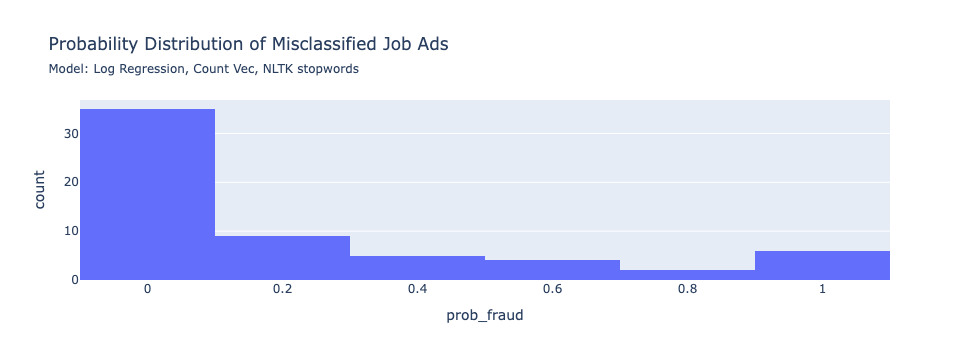

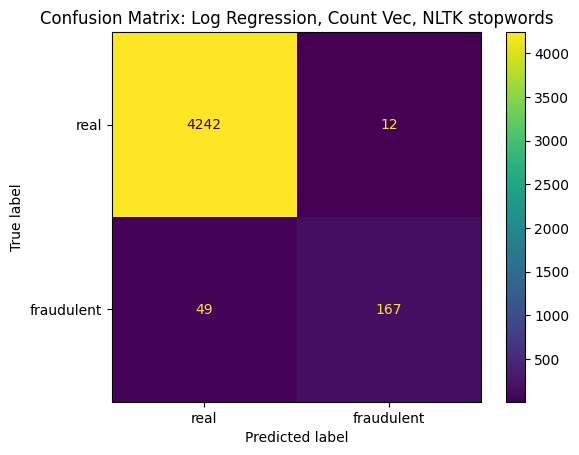

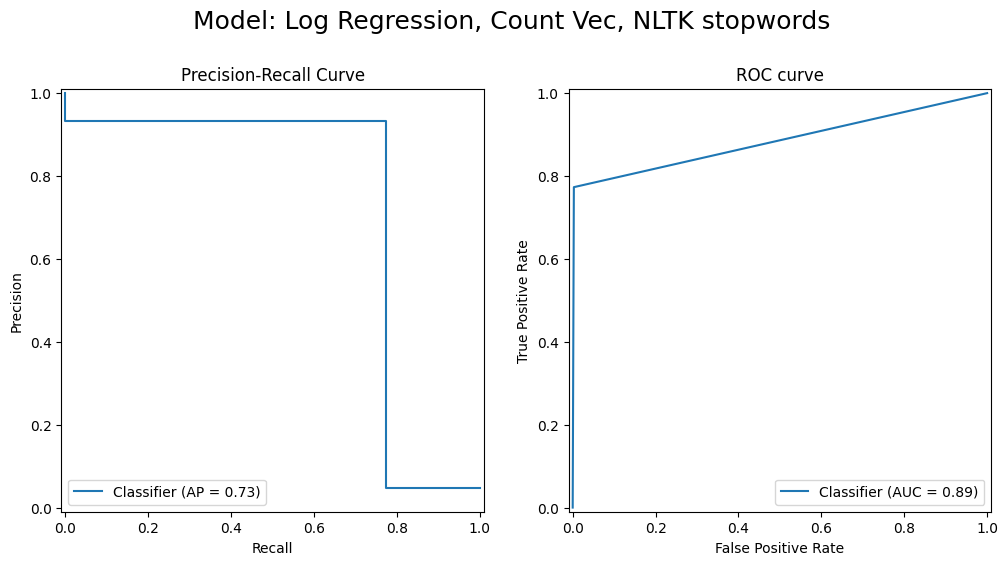

In [388]:
scores_log_cv_stop_nltk, res_log_cv_stop_nltk = evaluate_model(
    model_log_stop_nltk, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, NLTK stopwords', 
    short_name='log_cv_stop_nltk', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [175]:
save_model(model_log_stop_nltk, 'model_log_stop_nltk')

In [176]:
res_log_cv_stop_nltk.to_csv('../data/results/res_log_cv_stop_nltk.csv')

In [177]:
scores_log_cv_stop_nltk

{'model': 'log_cv_stop_nltk',
 'accuracy': 0.9863534675615212,
 'precision': 0.9329608938547486,
 'recall': 0.7731481481481481,
 'f1_score': 0.8455696202531645,
 'roc_auc_score': 0.885163636838531}

#### CV with spaCy Stopwords

In [178]:
model_log_stop_spacy = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2), stop_words= stopwords_spacy), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [179]:
model_log_stop_spacy.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              '’m',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'hereupon',
                                                                              'our',
                                                                              'thereafter',
                                                                              'give',
                                                                              'it',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              "'re",
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'full',
                                                                              'himself', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.91      0.78      0.84       216

    accuracy                           0.99      4470
   macro avg       0.95      0.89      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



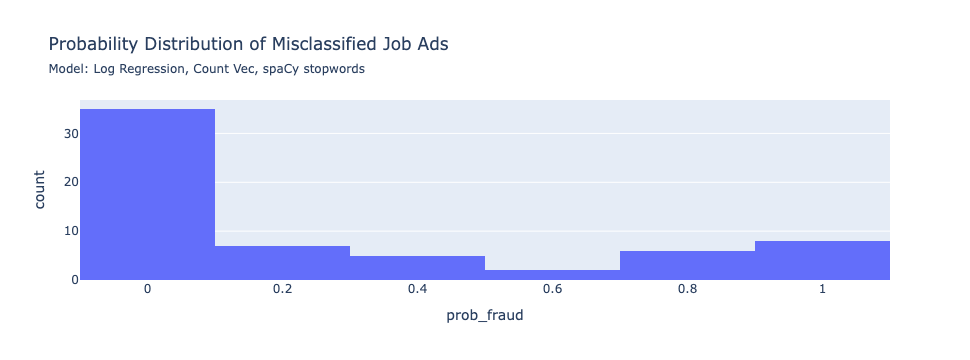

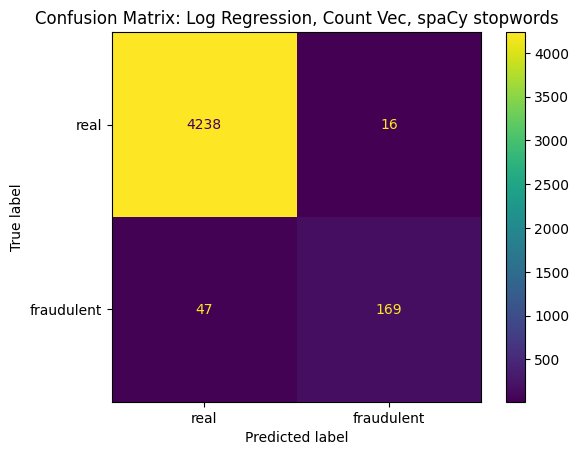

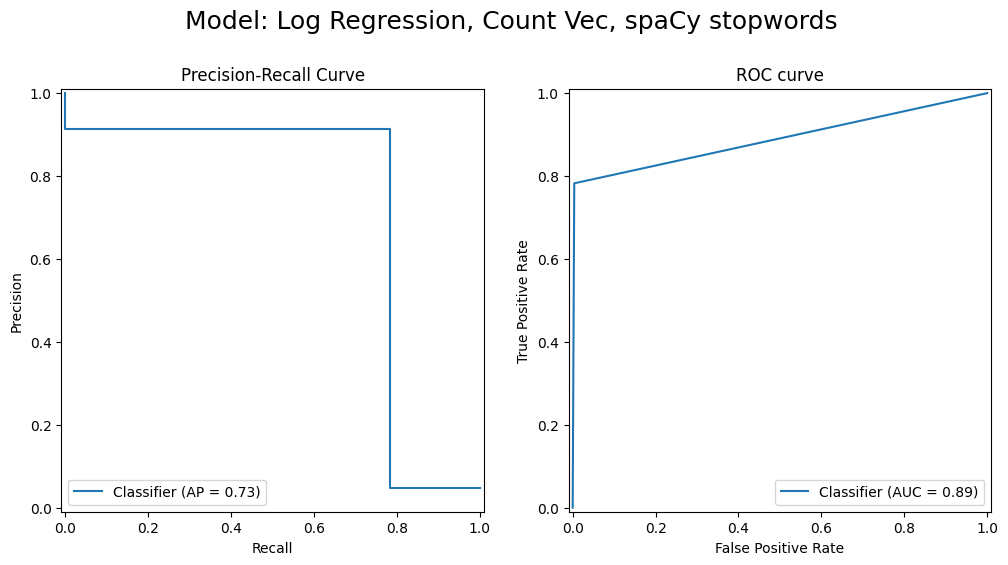

In [389]:
scores_log_cv_stop_spacy, res_log_cv_stop_spacy = evaluate_model(
    model_log_stop_spacy, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, spaCy stopwords', 
    short_name='log_cv_stop_spacy', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [181]:
save_model(model_log_stop_spacy, 'model_log_stop_spacy')

In [182]:
res_log_cv_stop_spacy.to_csv('../data/results/res_log_cv_stop_spacy.csv')

In [183]:
scores_log_cv_stop_spacy

{'model': 'log_cv_stop_spacy',
 'accuracy': 0.9859060402684564,
 'precision': 0.9135135135135135,
 'recall': 0.7824074074074074,
 'f1_score': 0.8428927680798005,
 'roc_auc_score': 0.8893231207229797}

#### CV with Gensim Stopwords

In [184]:
model_log_stop_gensim = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2), stop_words= stopwords_gensim), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [185]:
model_log_stop_gensim.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'our',
                                                                              'thereafter',
                                                                              'hereupon',
                                                                              'give',
                                                                              'it',
                                                                              'inc',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'ltd',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'found',
                                                                              'full', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.93      0.78      0.85       216

    accuracy                           0.99      4470
   macro avg       0.96      0.89      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



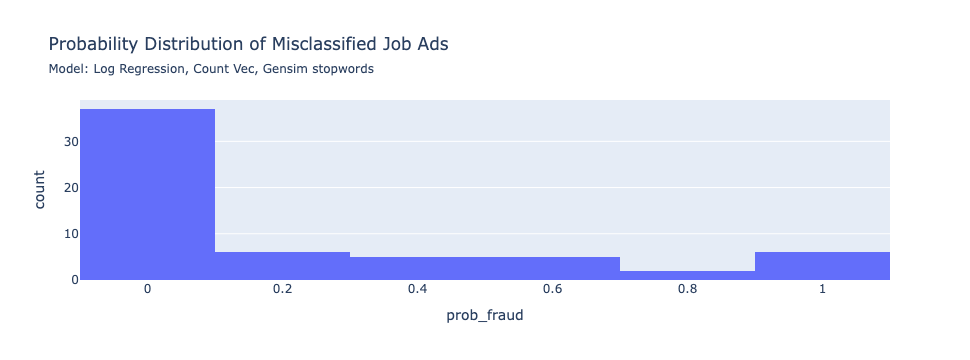

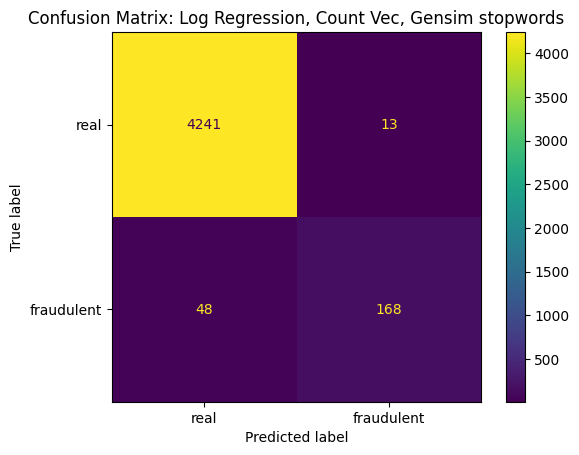

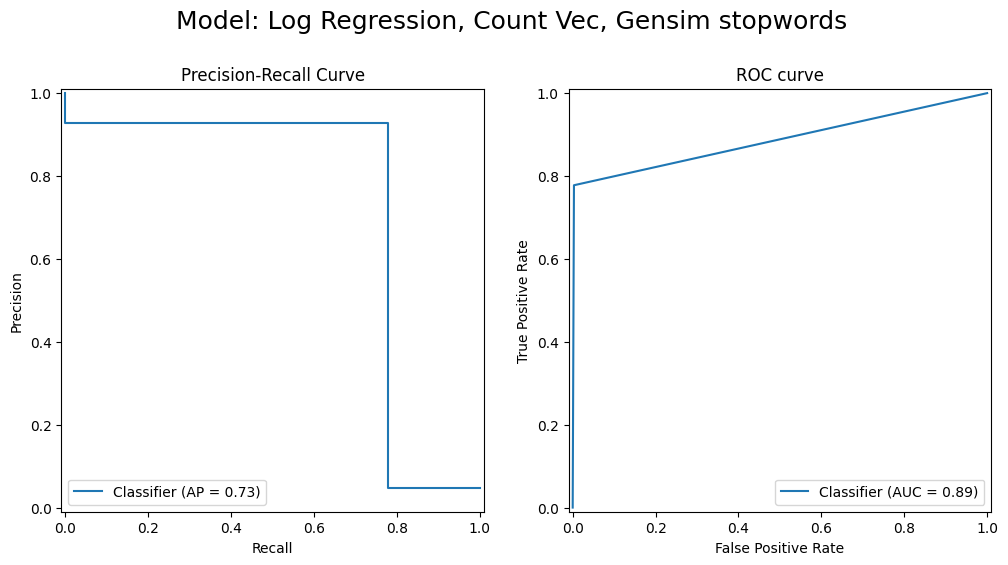

In [390]:
scores_log_cv_stop_gensim, res_log_cv_stop_gensim = evaluate_model(
    model_log_stop_gensim, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, Gensim stopwords', 
    short_name='log_cv_stop_gensim', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [187]:
save_model(model_log_stop_gensim, 'model_log_stop_gensim')

In [188]:
res_log_cv_stop_gensim.to_csv('../data/results/res_log_cv_stop_gensim.csv')

In [189]:
scores_log_cv_stop_gensim

{'model': 'log_cv_stop_gensim',
 'accuracy': 0.9863534675615212,
 'precision': 0.9281767955801105,
 'recall': 0.7777777777777778,
 'f1_score': 0.8463476070528967,
 'roc_auc_score': 0.8873609152170506}

#### Tf-Idf with Stop Words

In [190]:
model_log_tfidf_stop_sklearn = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words= 'english'), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [191]:
model_log_tfidf_stop_sklearn.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words='english'),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.83      0.77      0.80       216

    accuracy                           0.98      4470
   macro avg       0.91      0.88      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



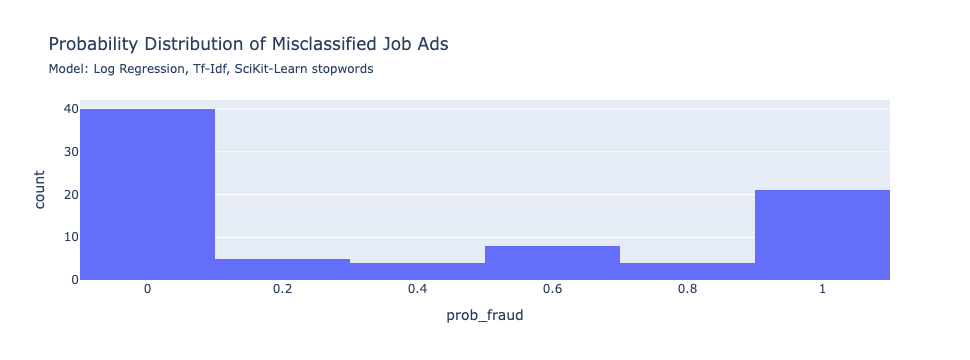

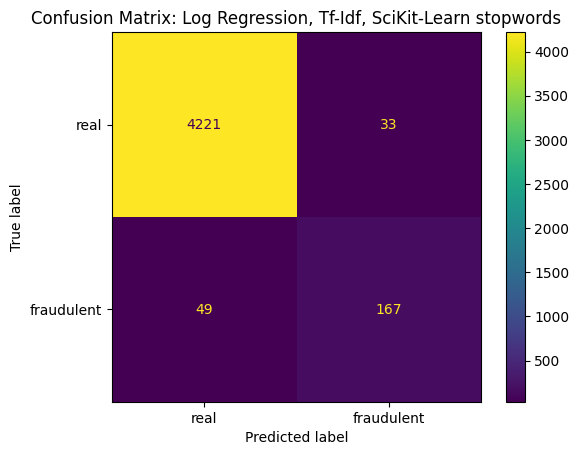

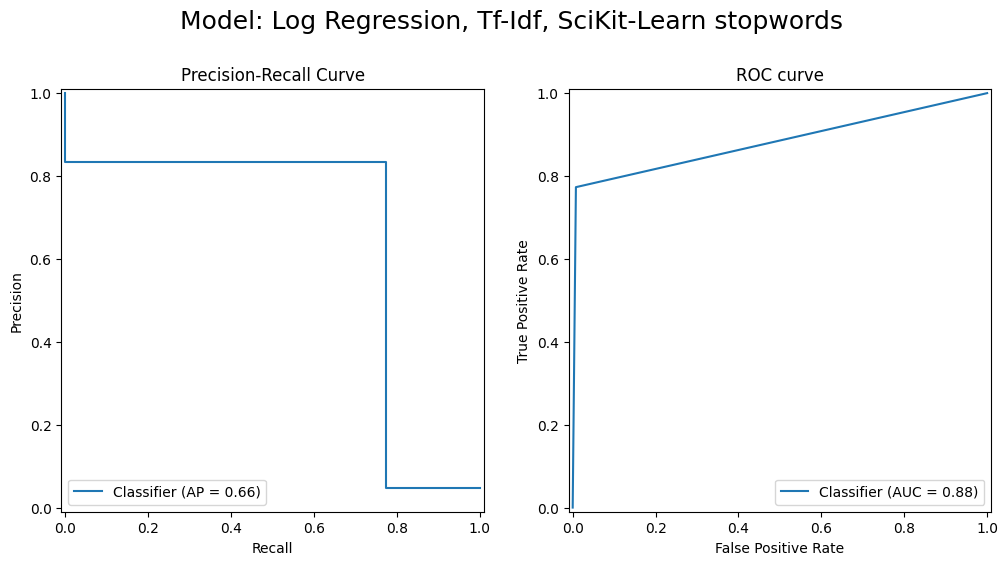

In [392]:
scores_log_tfidf_stop_sklearn, res_log_tfidf_stop_sklearn = evaluate_model(
    model_log_tfidf_stop_sklearn, X_test, y_test, 
    fig_subtitle= 'Log Regression, Tf-Idf, SciKit-Learn stopwords', 
    short_name='log_cv_tfidf_stop_sklearn', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [193]:
save_model(model_log_tfidf_stop_sklearn, 'model_log_tfidf_stop_sklearn')

In [194]:
res_log_tfidf_stop_sklearn.to_csv('../data/results/res_log_tfidf_stop_sklearn.csv')

In [195]:
scores_log_tfidf_stop_sklearn

{'model': 'log_cv_tfidf_stop_sklearn',
 'accuracy': 0.9816554809843401,
 'precision': 0.835,
 'recall': 0.7731481481481481,
 'f1_score': 0.8028846153846154,
 'roc_auc_score': 0.8826953716763307}

#### Tf-Idf with NLTK Stopwords

In [196]:
model_log_tidf_stop_nltk = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words= stopwords_nltk), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [197]:
model_log_tidf_stop_nltk.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['a',
                                                                              'about',
                                                                              'above',
                                                                              'after',
                                                                              'again',
                                                                              'against',
                                                                              'ain',
                                                                              'all',
                                                                              'am',
                                                                              'an',
                                                                              'and',
                                                                              'any',
                                                                              'are',
                                                                              'aren',
                                                                              "aren't",
                                                                              'as',
                                                                              'at',
                                                                              'be',
                                                                              'because',
                                                                              'been',
                                                                              'before',
                                                                              'being',
                                                                              'below',
                                                                              'between',
                                                                              'both',
                                                                              'but',
                                                                              'by',
                                                                              'can',
                                                                              'couldn',
                                                                              "couldn't", ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.84      0.78      0.81       216

    accuracy                           0.98      4470
   macro avg       0.92      0.89      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



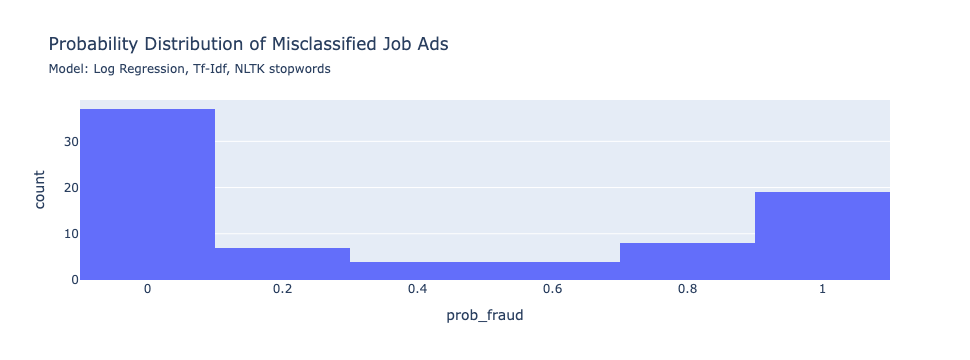

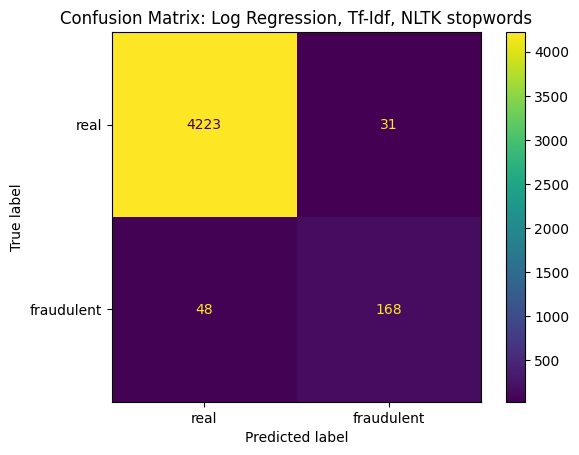

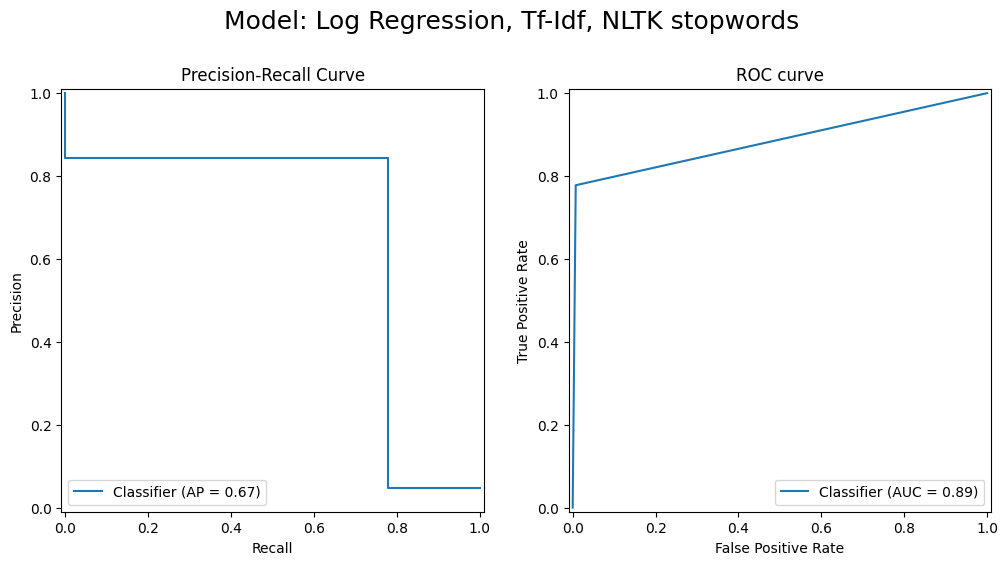

In [391]:
scores_log_tfidf_stop_nltk, res_log_tfidf_stop_nltk = evaluate_model(
    model_log_tidf_stop_nltk, X_test, y_test, 
    fig_subtitle= 'Log Regression, Tf-Idf, NLTK stopwords', 
    short_name='log_tfidf_stop_nltk', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [199]:
save_model(model_log_tidf_stop_nltk, 'model_log_tidf_stop_nltk')

In [200]:
res_log_tfidf_stop_nltk.to_csv('../data/results/res_log_tfidf_stop_nltk.csv')

In [201]:
scores_log_tfidf_stop_nltk

{'model': 'log_tfidf_stop_nltk',
 'accuracy': 0.9823266219239374,
 'precision': 0.8442211055276382,
 'recall': 0.7777777777777778,
 'f1_score': 0.8096385542168675,
 'roc_auc_score': 0.8852452593637361}

#### Tf-Idf with spaCy Stopwords

In [202]:
model_log_tfidf_stop_spacy = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words= stopwords_spacy), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [203]:
model_log_tfidf_stop_spacy.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.



Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              '’m',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'hereupon',
                                                                              'our',
                                                                              'thereafter',
                                                                              'give',
                                                                              'it',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              "'re",
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'full',
                                                                              'himself', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])

Actually getting this warning it a really good sign that progress has been made since the 2018 paper.  Including warnings like this was one of their recommendations.


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.84      0.78      0.81       216

    accuracy                           0.98      4470
   macro avg       0.91      0.89      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



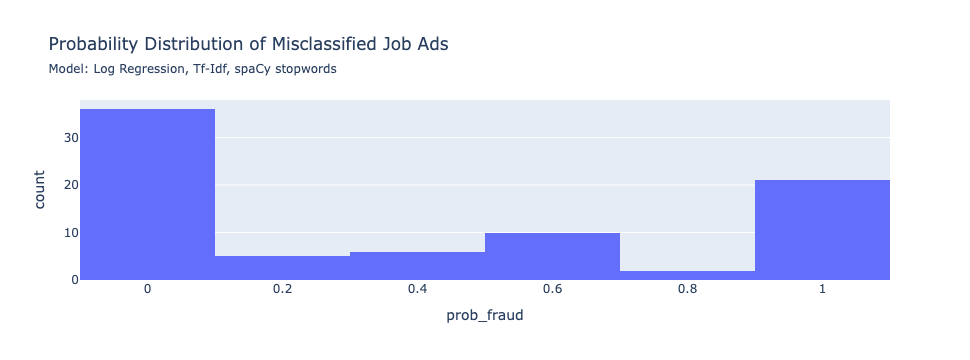

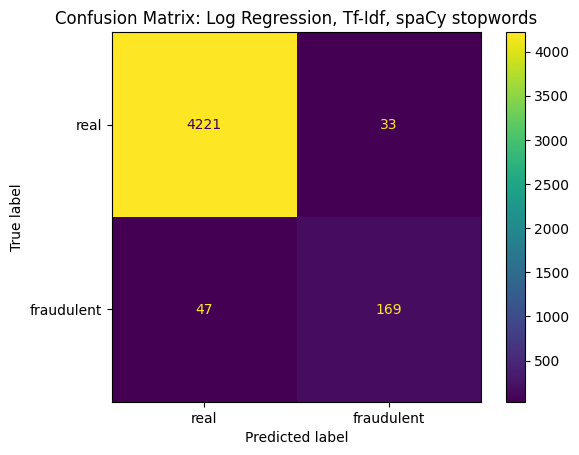

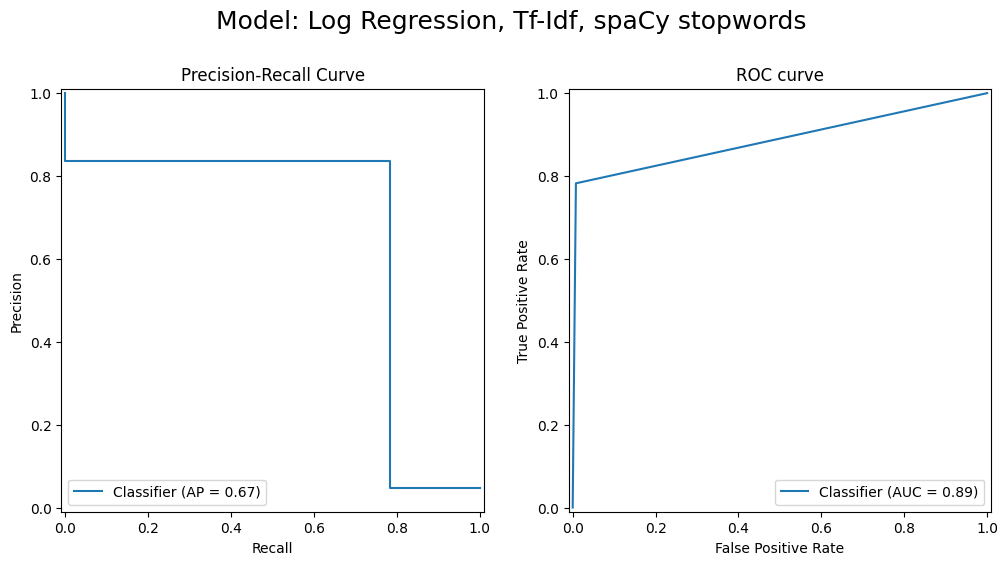

In [393]:
scores_log_tfidf_stop_spacy, res_log_tfidf_stop_spacy = evaluate_model(
    model_log_tfidf_stop_spacy, X_test, y_test, 
    fig_subtitle= 'Log Regression, Tf-Idf, spaCy stopwords', 
    short_name='log_tfidf_stop_spacy', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [205]:
save_model(model_log_tfidf_stop_spacy, 'model_log_tfidf_stop_spacy')

In [206]:
res_log_tfidf_stop_spacy.to_csv('../data/results/res_log_tfidf_stop_spacy.csv')

In [207]:
scores_log_tfidf_stop_spacy

{'model': 'log_tfidf_stop_spacy',
 'accuracy': 0.9821029082774049,
 'precision': 0.8366336633663366,
 'recall': 0.7824074074074074,
 'f1_score': 0.8086124401913876,
 'roc_auc_score': 0.8873250013059605}

#### Tf-Idf with Gensim Stopwords

In [208]:
model_log_tfidf_stop_gensim = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words= stopwords_gensim), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [209]:
model_log_tfidf_stop_gensim.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'our',
                                                                              'thereafter',
                                                                              'hereupon',
                                                                              'give',
                                                                              'it',
                                                                              'inc',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'ltd',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'found',
                                                                              'full', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.84      0.77      0.80       216

    accuracy                           0.98      4470
   macro avg       0.91      0.88      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



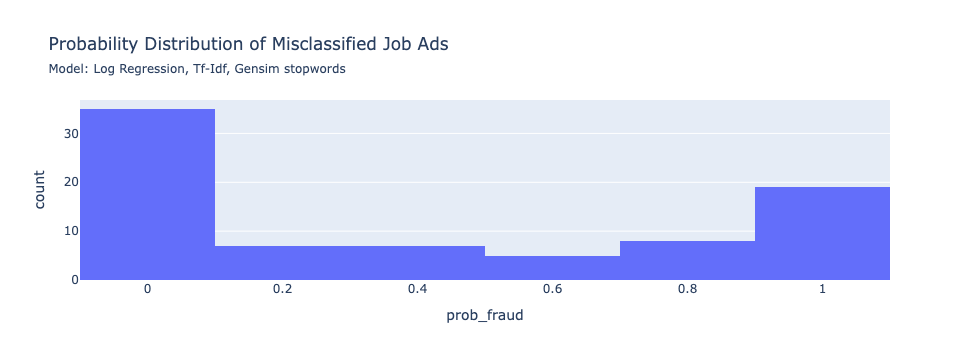

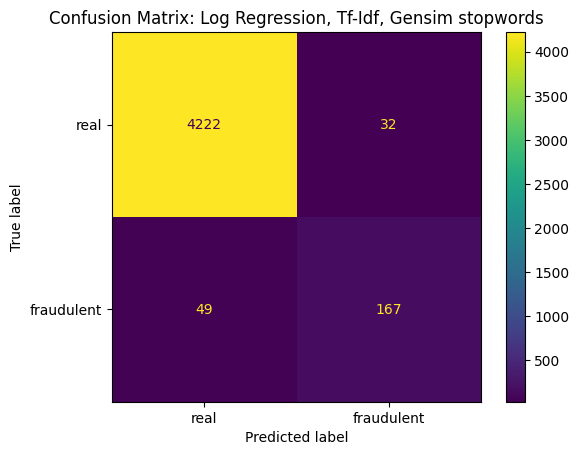

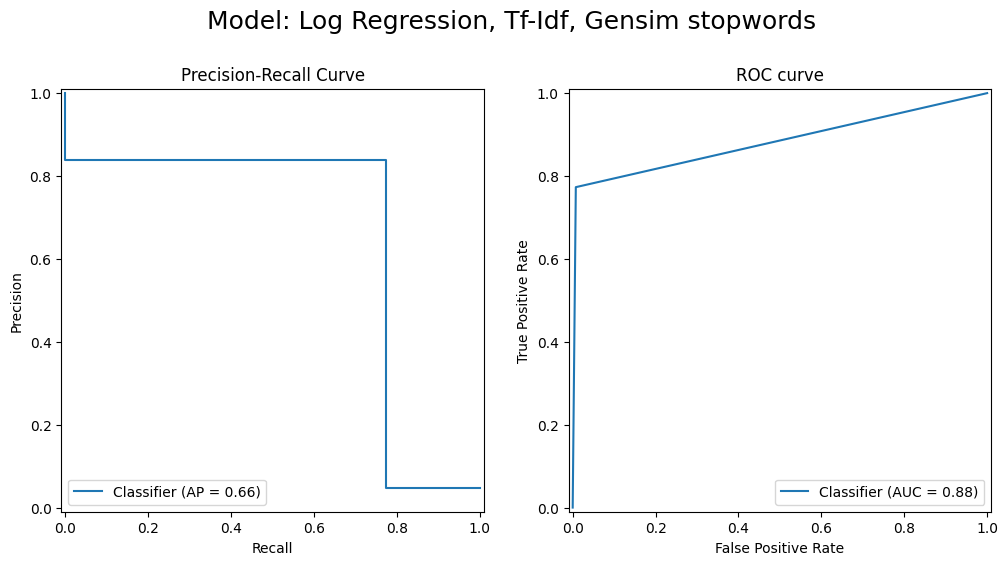

In [394]:
scores_log_tfidf_stop_gensim, res_log_tfidf_stop_gensim = evaluate_model(
    model_log_tfidf_stop_gensim, X_test, y_test, 
    fig_subtitle= 'Log Regression, Tf-Idf, Gensim stopwords', 
    short_name='log_tfidf_stop_gensim', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [211]:
save_model(model_log_tfidf_stop_gensim, 'model_log_tfidf_stop_gensim')

In [212]:
res_log_tfidf_stop_gensim.to_csv('../data/results/res_log_tfidf_stop_gensim.csv')

In [213]:
scores_log_tfidf_stop_gensim

{'model': 'log_tfidf_stop_gensim',
 'accuracy': 0.9818791946308725,
 'precision': 0.8391959798994975,
 'recall': 0.7731481481481481,
 'f1_score': 0.8048192771084337,
 'roc_auc_score': 0.882812908112626}

#### Summary with Stop Words

In [395]:
pd.DataFrame([
    scores_base, scores_log_cv, scores_log_cv_stop_sklearn, 
    scores_log_cv_stop_nltk, scores_log_cv_stop_spacy, scores_log_cv_stop_gensim, 
    scores_log_tfidf, scores_log_tfidf_stop_sklearn, 
    scores_log_tfidf_stop_nltk, scores_log_tfidf_stop_spacy, scores_log_tfidf_stop_gensim
]).style.apply(
    highlight_max, props='color:white; background-color:darkblue', axis=0, 
    subset=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
)

The F1 score improve with the addition of stop words, but it is a small gain (about 0.5%).  I will need to explore the size of other contributions / improvements before making a final decision on this.  However I will use the Gensim stopword list when needed.

## Principal Component Analysis (PCA)

Principle Component Analysis (PCA) simply finds new coordinate system in parameter space.  It uses linear combinations of our original data to better predict the results.  This is similar to finding eigenvectors for a matrix (the features) or rescaling our original parameters by different amounts and do a crazy multi-dimensional rotation in our parameter space.  It's actually fairly straightforward linear algebra, but this is usually taught after 2-3 semesters of calculus, so not as many people get to study it.  

### Principal Component Analysis (PCA), with Count Vectorizer

#### Initial Attempt

In [215]:
model_log_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None))
])

In [216]:
model_log_pca.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4254
  fraudulent       0.81      0.32      0.46       216

    accuracy                           0.96      4470
   macro avg       0.89      0.66      0.72      4470
weighted avg       0.96      0.96      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



{'model': 'log',
 'accuracy': 0.9635346756152126,
 'precision': 0.8117647058823529,
 'recall': 0.3194444444444444,
 'f1_score': 0.4584717607973422,
 'roc_auc_score': 0.6578416392414982}

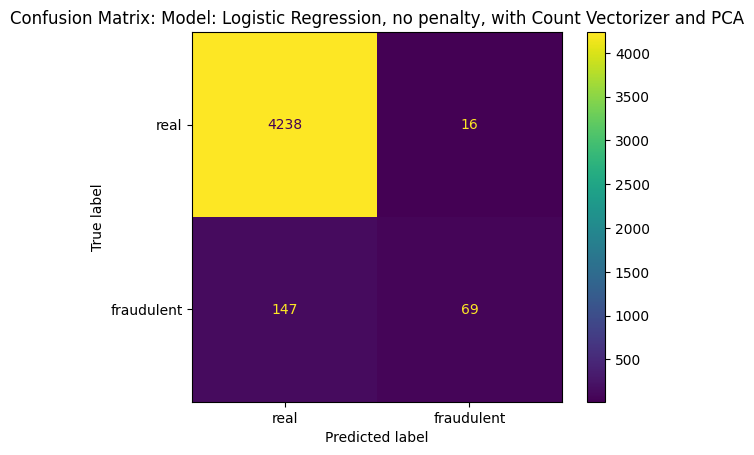

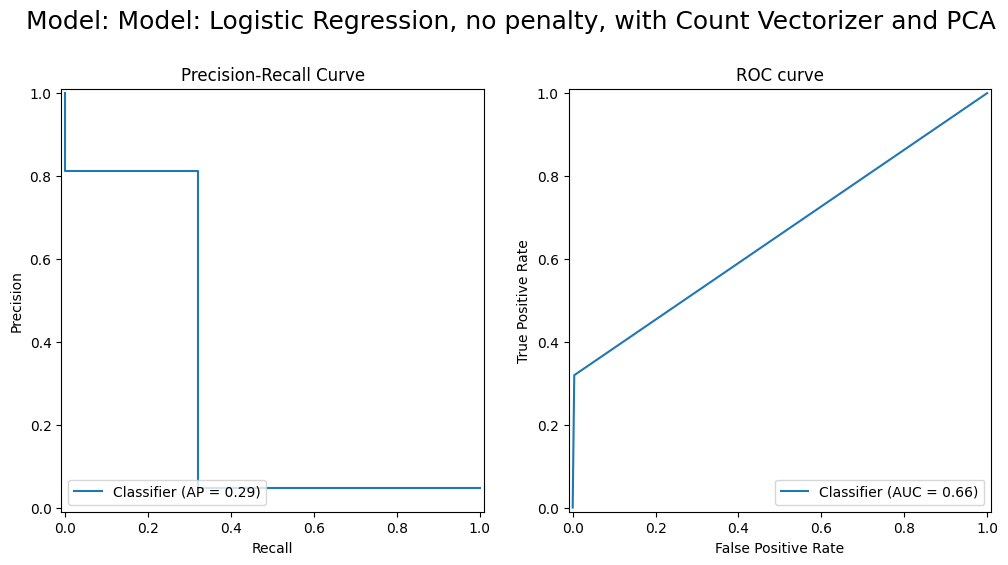

In [217]:
evaluate_model(model_log_pca, X_test, y_test, 
               fig_subtitle= 'Model: Logistic Regression, no penalty, with Count Vectorizer and PCA', short_name='log')

This is heading in the right direction, the misclassified job ads are less certain than they were previously.  

#### Increase max iterations

In [218]:
model_log_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [219]:
model_log_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4254
  fraudulent       0.82      0.31      0.45       216

    accuracy                           0.96      4470
   macro avg       0.89      0.66      0.72      4470
weighted avg       0.96      0.96      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



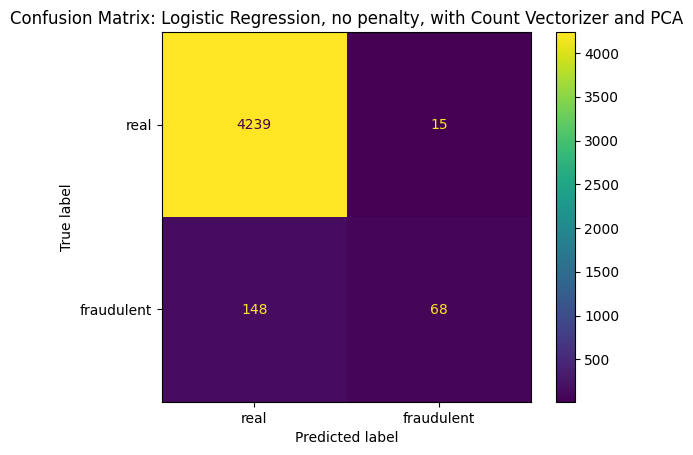

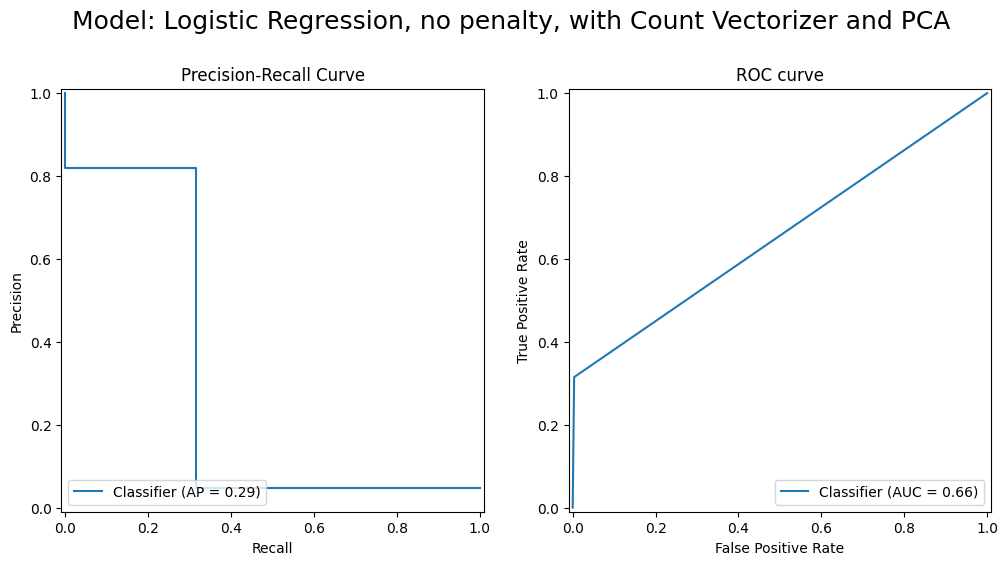

In [220]:
scores_log_cv_pca, res_log_cv_pca = evaluate_model(
    model_log_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA', 
    short_name='log_cv_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [221]:
save_model(model_log_pca, 'model_cv_pca_log')

In [222]:
res_log_cv_pca.to_csv('../data/results/res_log_cv_pca.csv')

#### Changing PCA number of components

##### 200 Components

In [223]:
model_log_pca_200 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [224]:
model_log_pca_200.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      0.99      0.98      4254
  fraudulent       0.82      0.50      0.62       216

    accuracy                           0.97      4470
   macro avg       0.90      0.74      0.80      4470
weighted avg       0.97      0.97      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



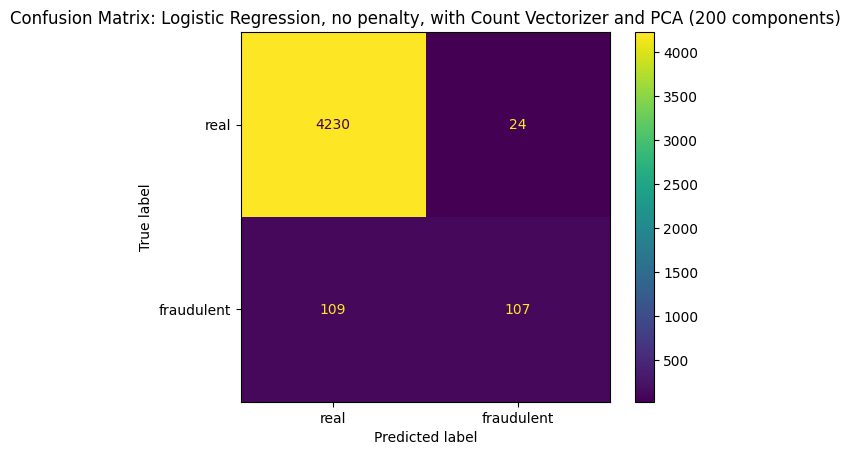

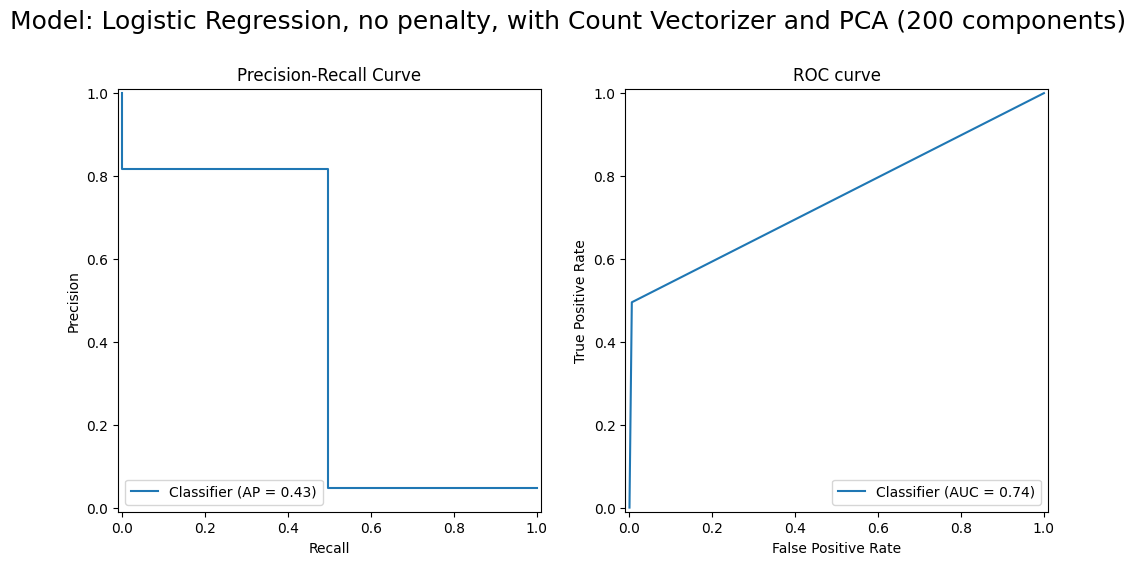

In [225]:
scores_log_cv_pca_200, res_log_cv_pca_200 = evaluate_model(
    model_log_pca_200, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (200 components)', 
    short_name='log_cv_pca_200', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [226]:
save_model(model_log_pca_200, 'model_log_cv_pca_200')

In [227]:
res_log_cv_pca_200.to_csv('../data/results/res_log_cv_pca_200.csv')

In [228]:
scores_log_cv_pca_200

{'model': 'log_cv_pca_200',
 'accuracy': 0.9702460850111857,
 'precision': 0.816793893129771,
 'recall': 0.49537037037037035,
 'f1_score': 0.6167146974063401,
 'roc_auc_score': 0.7448643107140992}

##### 300 Components

In [229]:
model_log_pca_300 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=300)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [230]:
model_log_pca_300.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=300)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])

/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown




Classification Report: 

              precision    recall  f1-score   support

        real       0.98      0.99      0.99      4254
  fraudulent       0.76      0.60      0.67       216

    accuracy                           0.97      4470
   macro avg       0.87      0.79      0.83      4470
weighted avg       0.97      0.97      0.97      4470



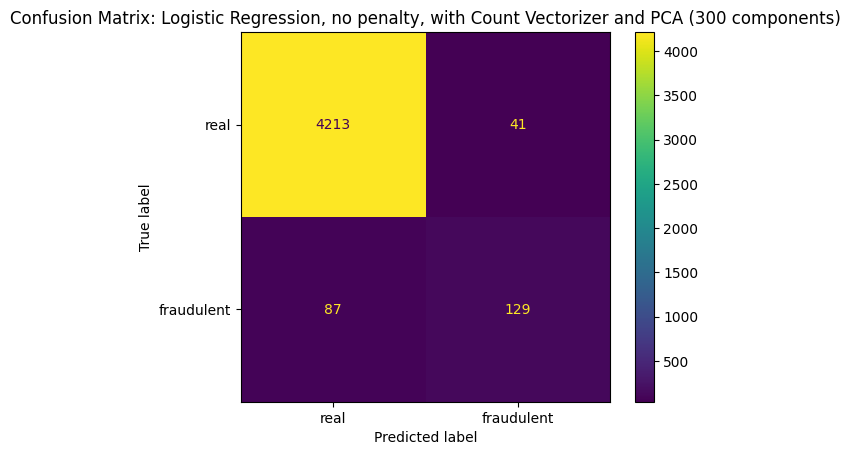

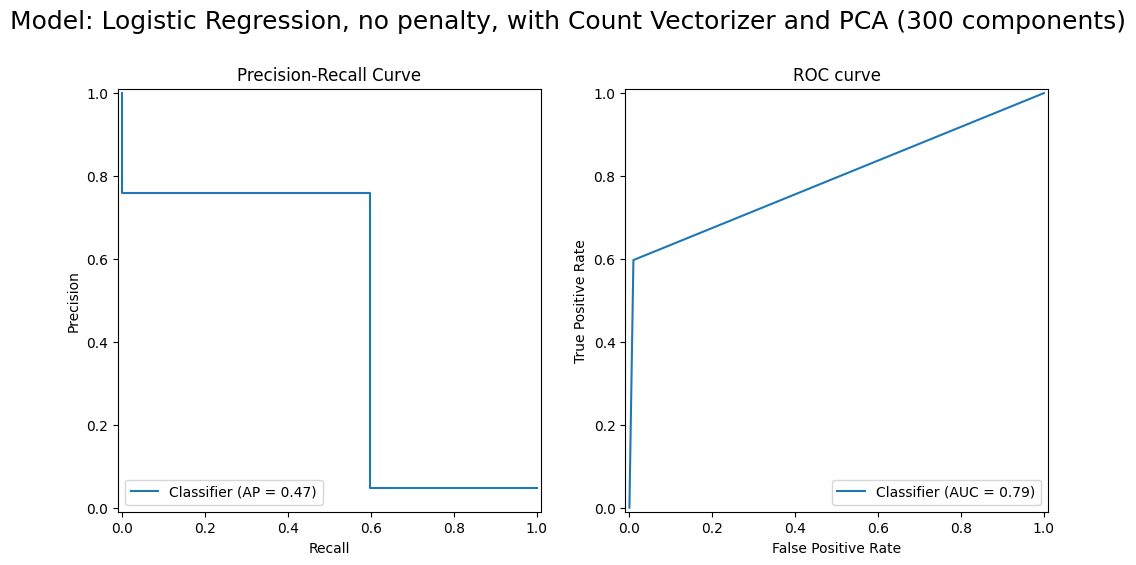

In [231]:
scores_log_cv_pca_300, res_log_cv_pca_300 = evaluate_model(
    model_log_pca_300, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (300 components)', 
    short_name='log_cv_pca_300', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [232]:
save_model(model_log_pca_300, 'model_log_cv_pca_300')

In [233]:
res_log_cv_pca_300.to_csv('../data/results/res_log_cv_pca_300.csv')

In [234]:
scores_log_cv_pca_300

{'model': 'log_cv_pca_300',
 'accuracy': 0.9713646532438479,
 'precision': 0.7588235294117647,
 'recall': 0.5972222222222222,
 'f1_score': 0.6683937823834197,
 'roc_auc_score': 0.7937921172230059}

##### 500 components

In [235]:
model_log_pca_500 = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=500)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [236]:
model_log_pca_500.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=500)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.76      0.72      0.74       216

    accuracy                           0.98      4470
   macro avg       0.87      0.85      0.86      4470
weighted avg       0.97      0.98      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



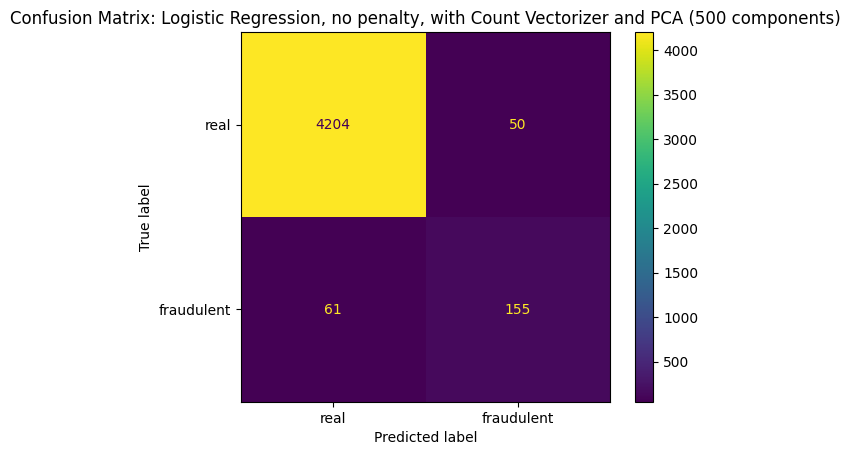

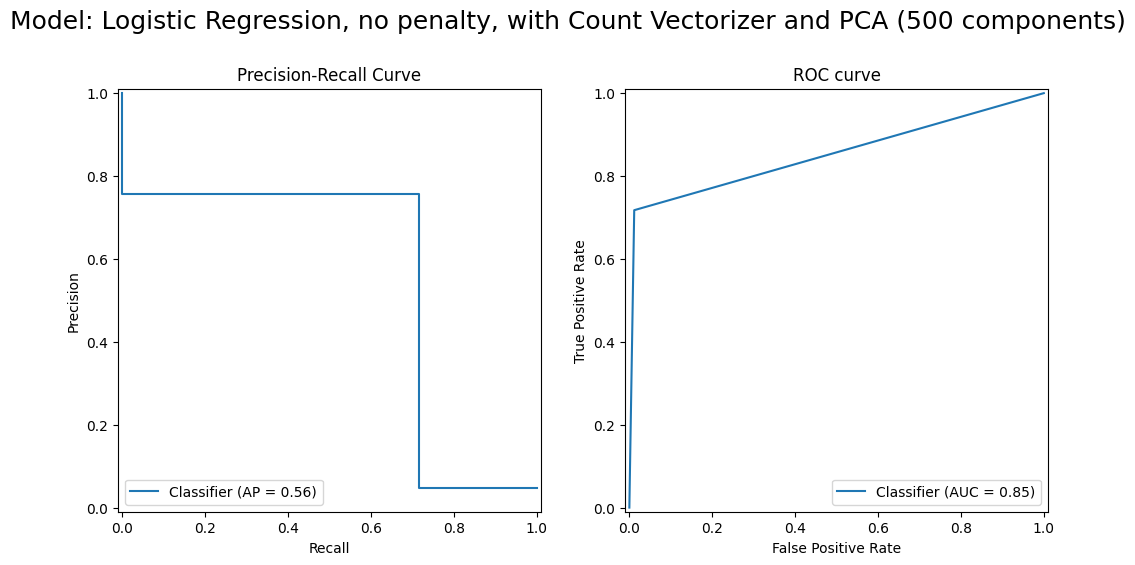

In [237]:
scores_log_cv_pca_500, res_log_cv_pca_500 = evaluate_model(
    model_log_pca_500, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer and PCA (500 components)', 
    short_name='log_cv_pca_500', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [238]:
save_model(model_log_pca_500, 'model_log_pca_500')

In [239]:
res_log_cv_pca_500.to_csv('../data/results/res_log_cv_pca_500.csv')

In [240]:
scores_log_cv_pca_500

{'model': 'log_cv_pca_500',
 'accuracy': 0.9751677852348993,
 'precision': 0.7560975609756098,
 'recall': 0.7175925925925926,
 'f1_score': 0.7363420427553444,
 'roc_auc_score': 0.8529194744815337}

#### Excluding Stop Words

Let's see if excluding stopwords improves our model or not.

In [331]:
model_log_pca_stop = Pipeline([
    ('ct', ColumnTransformer([
        ('cvec', CountVectorizer(ngram_range=(1,2), stop_words = stopwords_gensim), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [332]:
model_log_pca_stop.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cvec',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'our',
                                                                              'thereafter',
                                                                              'hereupon',
                                                                              'give',
                                                                              'it',
                                                                              'inc',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'ltd',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'found',
                                                                              'full', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      1.00      0.98      4254
  fraudulent       0.82      0.43      0.56       216

    accuracy                           0.97      4470
   macro avg       0.89      0.71      0.77      4470
weighted avg       0.96      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



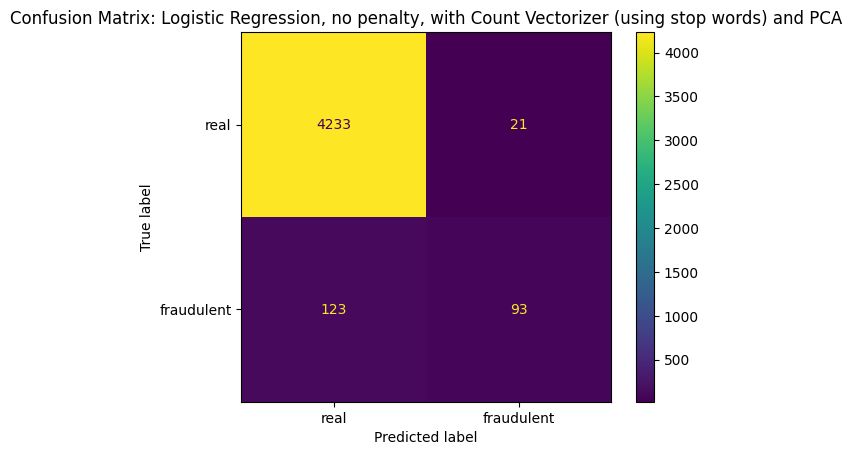

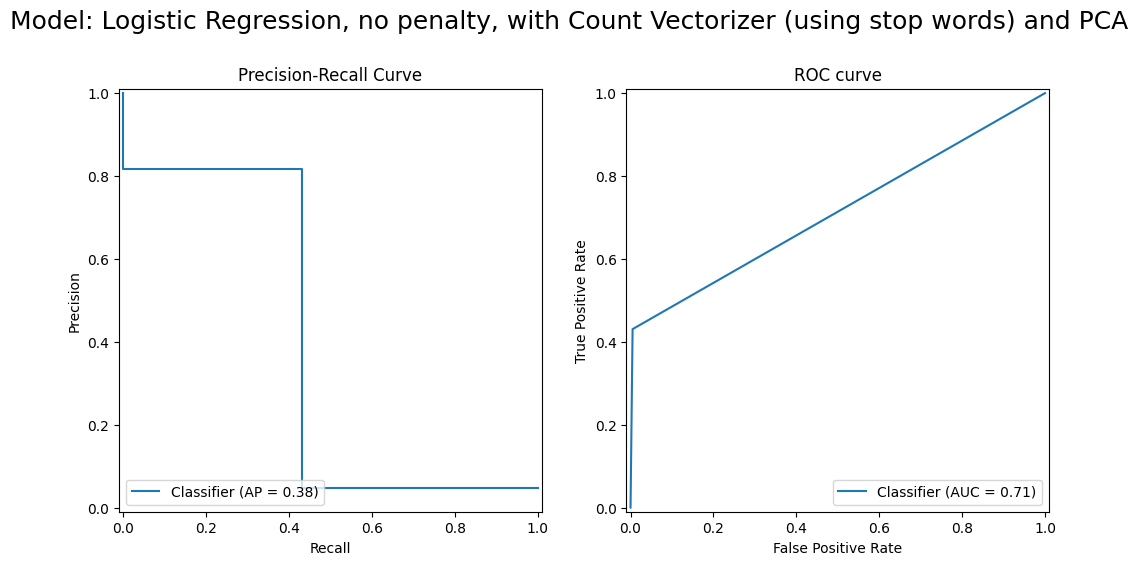

In [333]:
scores_log_cv_pca_stop, res_log_cv_pca_stop = evaluate_model(
    model_log_pca_stop, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Count Vectorizer (using stop words) and PCA', 
    short_name='log_cv_pca_stop', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [334]:
res_log_cv_pca_stop.to_csv('../data/results/res_log_cv_pca_stop.csv')

In [335]:
save_model(model_log_pca_stop, 'model_log_cv_pca_stop')

In [336]:
scores_log_cv_pca_stop

{'model': 'log_cv_pca_stop',
 'accuracy': 0.9677852348993289,
 'precision': 0.8157894736842105,
 'recall': 0.4305555555555556,
 'f1_score': 0.5636363636363636,
 'roc_auc_score': 0.7128095126155775}

### Principal Component Analysis (PCA) with TF-IDF Vectorizer

#### Initial Model

In [247]:
model_log_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None))
])

In [248]:
model_log_tfidf_pca.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      0.99      0.98      4254
  fraudulent       0.77      0.48      0.59       216

    accuracy                           0.97      4470
   macro avg       0.87      0.73      0.79      4470
weighted avg       0.96      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



{'model': 'log_tfidf_pca_no_converge',
 'accuracy': 0.9677852348993289,
 'precision': 0.7686567164179104,
 'recall': 0.47685185185185186,
 'f1_score': 0.5885714285714285,
 'roc_auc_score': 0.7347822964007732}

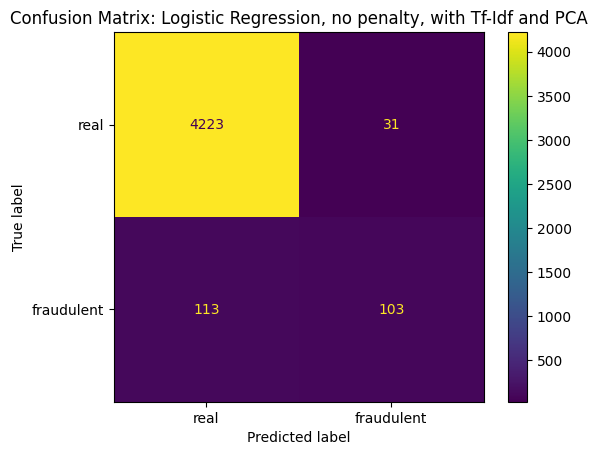

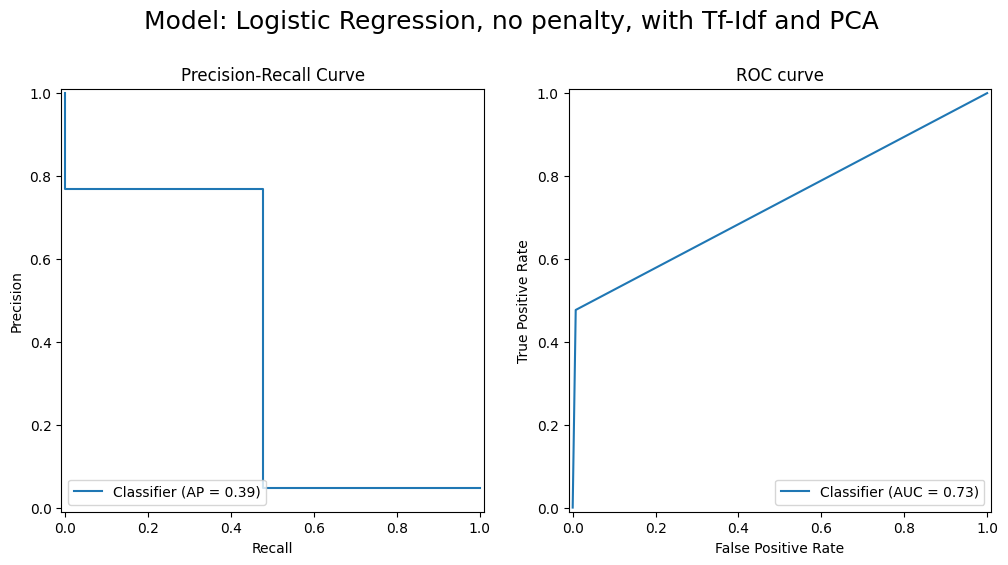

In [249]:
evaluate_model(model_log_tfidf_pca, X_test, y_test, 
               fig_subtitle= 'Logistic Regression, no penalty, with Tf-Idf and PCA', 
               short_name='log_tfidf_pca_no_converge')

This is heading in the right direction, the misclassified job ads are less certain than they were previously.  

#### Increase max iterations

In [250]:
model_log_tfidf_pca = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=100)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [251]:
model_log_tfidf_pca.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=100)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.97      0.99      0.98      4254
  fraudulent       0.76      0.46      0.58       216

    accuracy                           0.97      4470
   macro avg       0.87      0.73      0.78      4470
weighted avg       0.96      0.97      0.96      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



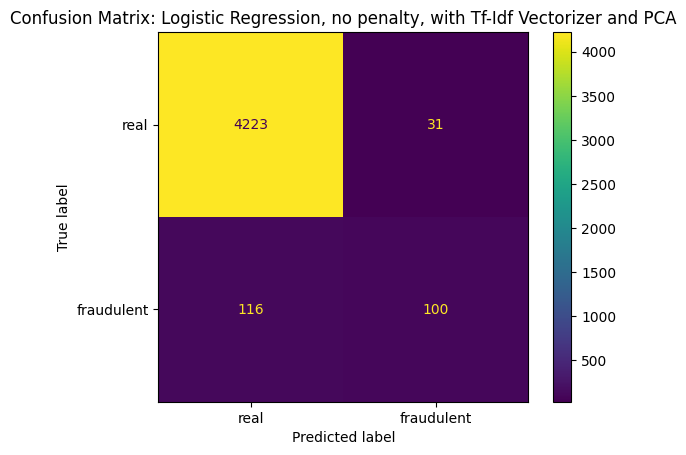

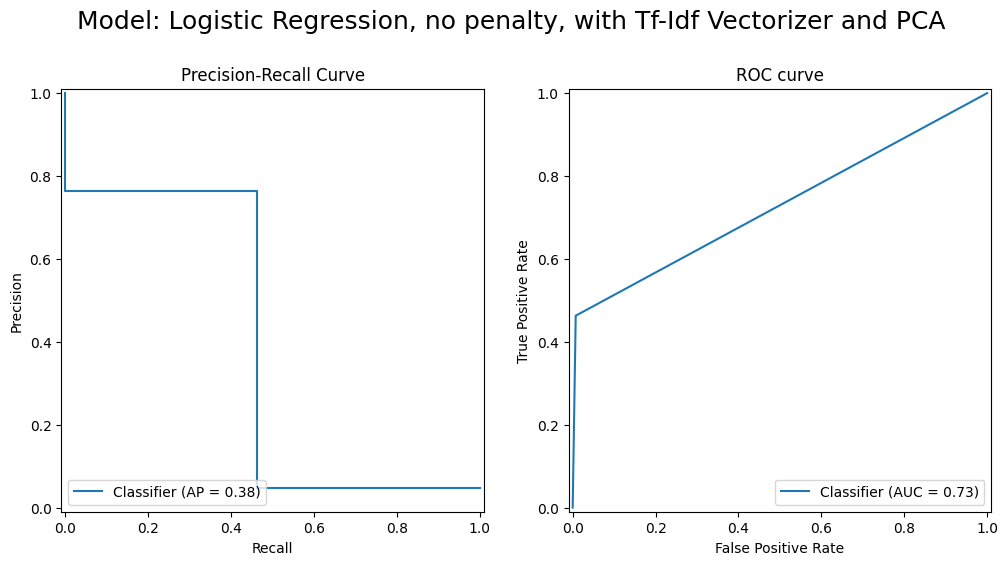

In [252]:
scores_log_tfidf_pca, res_log_tfidf_pca = evaluate_model(
    model_log_tfidf_pca, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Tf-Idf Vectorizer and PCA', 
    short_name='log_tfidfj_pca', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [253]:
save_model(model_log_tfidf_pca, 'model_tfidf_pca_log')

In [254]:
res_log_tfidf_pca.to_csv('../data/results/res_log_tfidf_pca.csv')

#### Changing PCA number of components

##### 200 Components

In [255]:
model_log_tfidf_pca_200 = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [256]:
model_log_tfidf_pca_200.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.86      0.58      0.69       216

    accuracy                           0.98      4470
   macro avg       0.92      0.79      0.84      4470
weighted avg       0.97      0.98      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



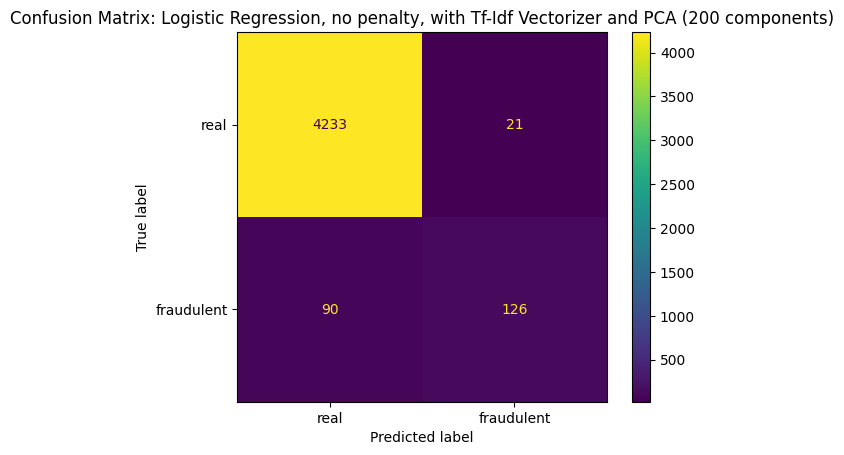

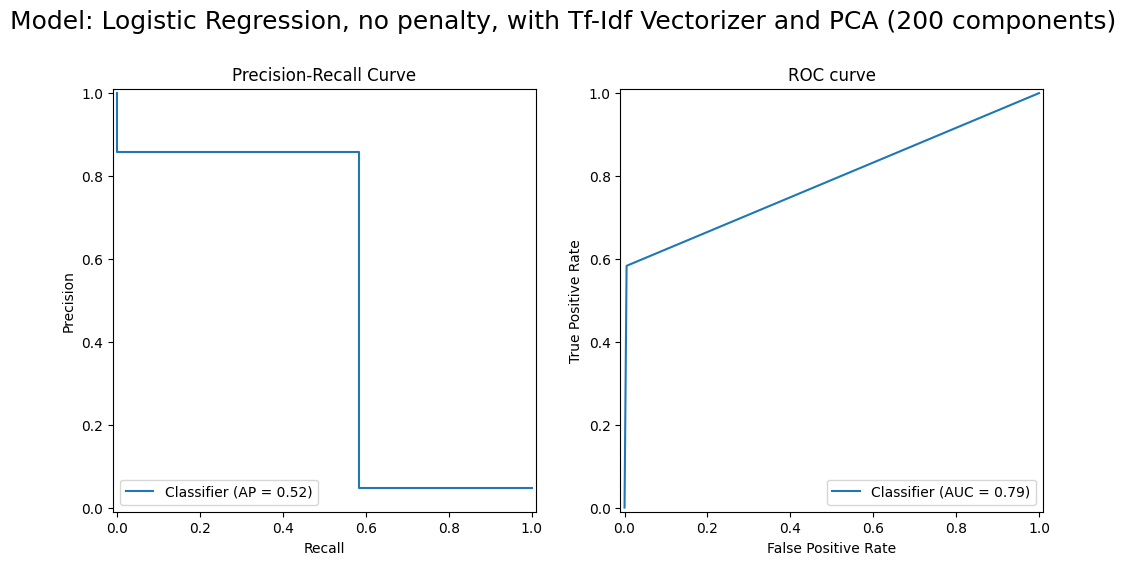

In [257]:
scores_log_tfidf_pca_200, res_log_tfidf_pca_200 = evaluate_model(
    model_log_tfidf_pca_200, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Tf-Idf Vectorizer and PCA (200 components)', 
    short_name='log_tfidf_pca_200', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [258]:
save_model(model_log_tfidf_pca_200, 'model_log_tfidf_pca_200')

In [259]:
res_log_tfidf_pca_200.to_csv('../data/results/res_log_tfidf_pca_200.csv')

In [260]:
scores_log_tfidf_pca_200

{'model': 'log_tfidf_pca_200',
 'accuracy': 0.9751677852348993,
 'precision': 0.8571428571428571,
 'recall': 0.5833333333333334,
 'f1_score': 0.6942148760330579,
 'roc_auc_score': 0.7891984015044665}

##### 300 Components

In [261]:
model_log_tfidf_pca_300 = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=300)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [262]:
model_log_tfidf_pca_300.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=300)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.88      0.65      0.74       216

    accuracy                           0.98      4470
   macro avg       0.93      0.82      0.87      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



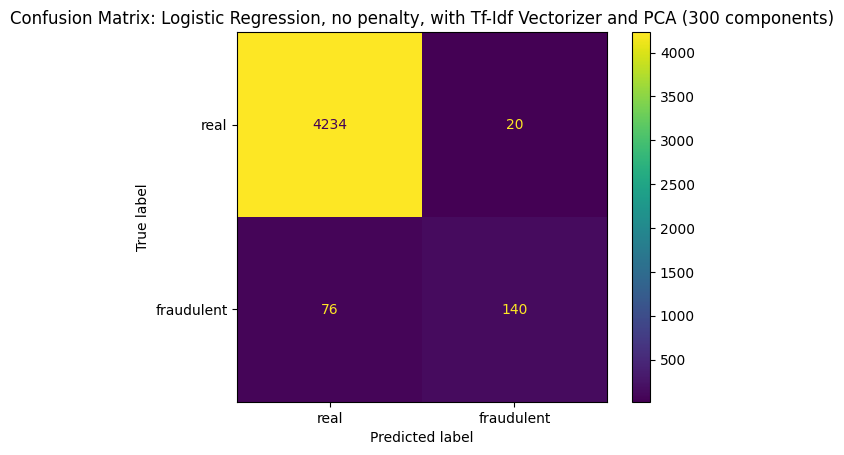

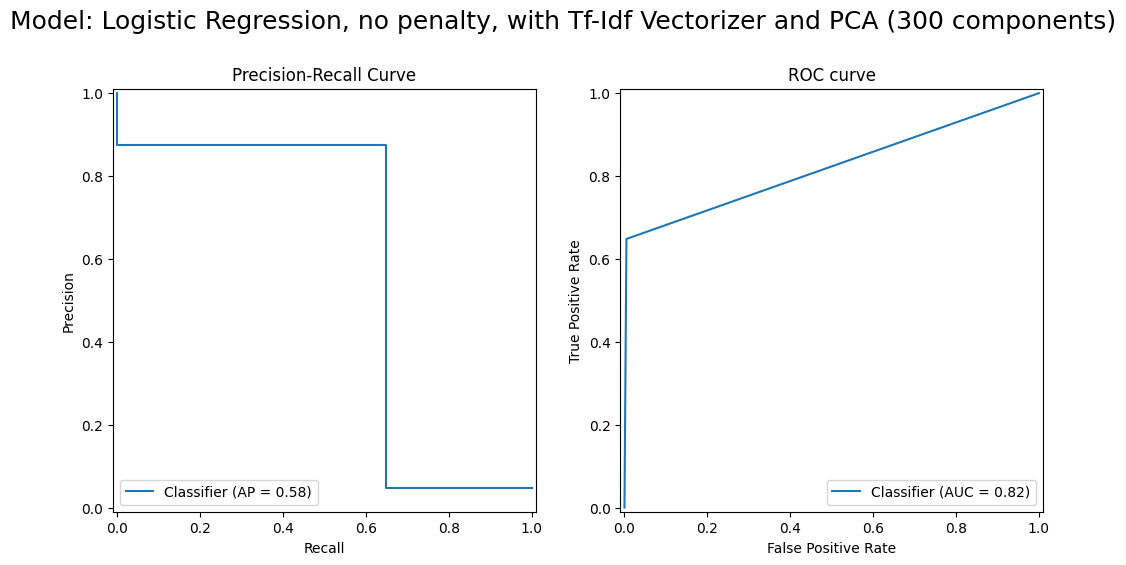

In [263]:
scores_log_tfidf_pca_300, res_log_tfidf_pca_300 = evaluate_model(
    model_log_tfidf_pca_300, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Tf-Idf Vectorizer and PCA (300 components)', 
    short_name='log_tfidf_pca_300', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [264]:
save_model(model_log_tfidf_pca_300, 'model_log_tfidf_pca_300')

In [265]:
res_log_tfidf_pca_300.to_csv('../data/results/res_log_tfidf_pca_300.csv')

In [266]:
scores_log_tfidf_pca_300

{'model': 'log_tfidf_pca_300',
 'accuracy': 0.978523489932886,
 'precision': 0.875,
 'recall': 0.6481481481481481,
 'f1_score': 0.7446808510638298,
 'roc_auc_score': 0.821723345348169}

##### 500 components

In [267]:
model_log_tfidf_pca_500 = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=500)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [268]:
model_log_tfidf_pca_500.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=500)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      4254
  fraudulent       0.87      0.71      0.78       216

    accuracy                           0.98      4470
   macro avg       0.93      0.85      0.89      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



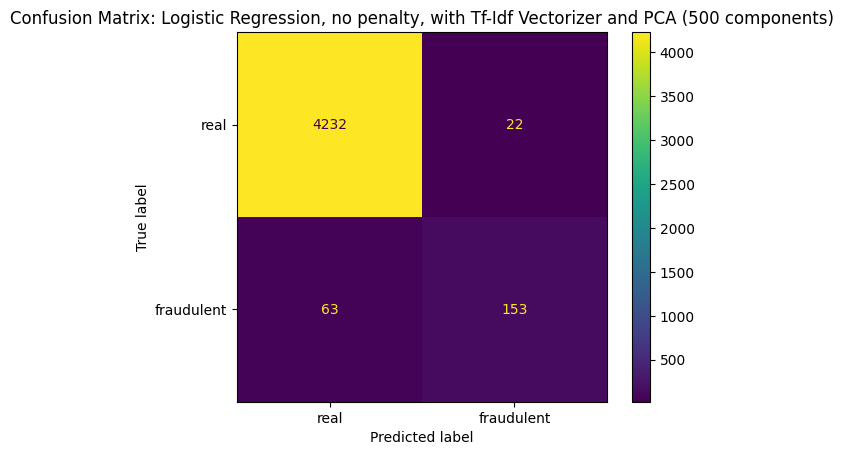

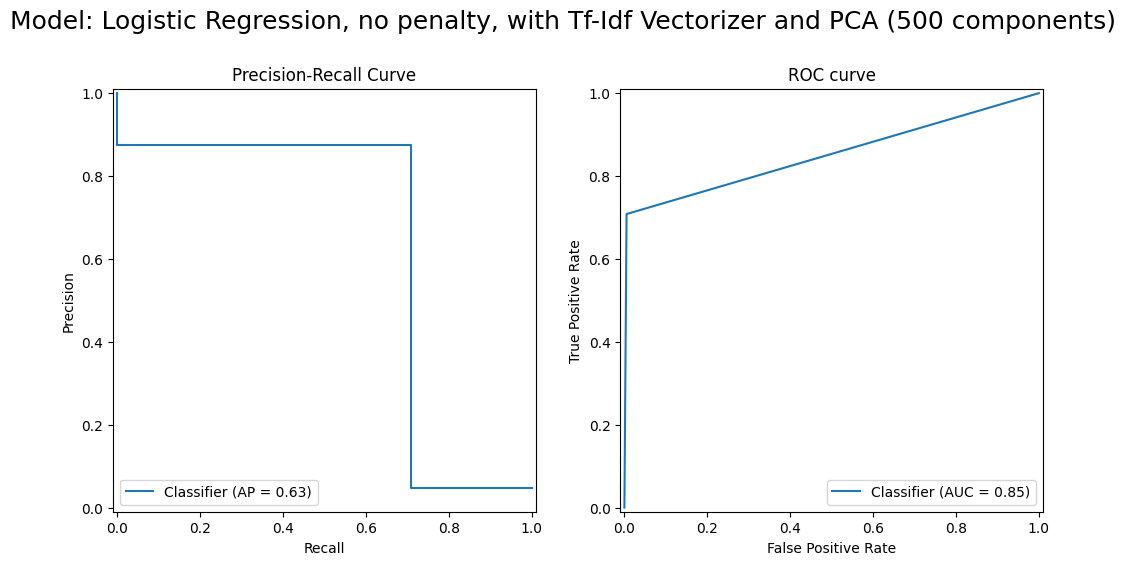

In [269]:
scores_log_tfidf_pca_500, res_log_tfidf_pca_500 = evaluate_model(
    model_log_tfidf_pca_500, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, no penalty, with Tf-Idf Vectorizer and PCA (500 components)', 
    short_name='log_tfidf_pca_500', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [270]:
save_model(model_log_tfidf_pca_500, 'model_log_tfidf_pca_500')

In [271]:
res_log_tfidf_pca_500.to_csv('../data/results/res_log_tfidf_pca_500.csv')

In [272]:
scores_log_tfidf_pca_500

{'model': 'log_tfidf_pca_500',
 'accuracy': 0.9809843400447428,
 'precision': 0.8742857142857143,
 'recall': 0.7083333333333334,
 'f1_score': 0.782608695652174,
 'roc_auc_score': 0.8515808650681712}

#### Excluding Stop Words

Let's see what happens if we exclude stopwords and perform PCA.

In [337]:
model_log_tfidf_pca_stop = Pipeline([
    ('ct', ColumnTransformer([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), stop_words = stopwords_gensim), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('pca', PCA(n_components=200)),
    ('log', LogisticRegression(penalty=None, max_iter=500))
])

In [338]:
model_log_tfidf_pca_stop.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['bottom',
                                                                              'their',
                                                                              'ten',
                                                                              'nowhere',
                                                                              'whose',
                                                                              'our',
                                                                              'thereafter',
                                                                              'hereupon',
                                                                              'give',
                                                                              'it',
                                                                              'inc',
                                                                              'than',
                                                                              'of',
                                                                              'where',
                                                                              'up',
                                                                              'first',
                                                                              'may',
                                                                              'nor',
                                                                              'we',
                                                                              'whenever',
                                                                              'with',
                                                                              'ltd',
                                                                              'had',
                                                                              'sixty',
                                                                              'this',
                                                                              'keep',
                                                                              'make',
                                                                              'doing',
                                                                              'found',
                                                                              'full', ...]),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('pca', PCA(n_components=200)),
                ('log', LogisticRegression(max_iter=500, penalty=None))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.87      0.58      0.70       216

    accuracy                           0.98      4470
   macro avg       0.92      0.79      0.84      4470
weighted avg       0.97      0.98      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



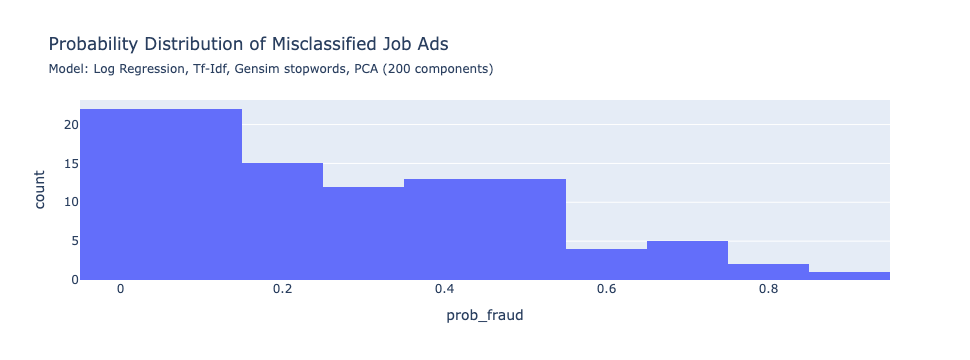

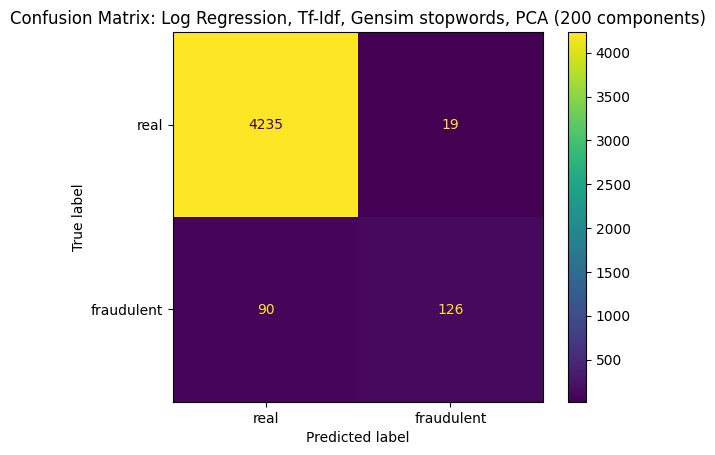

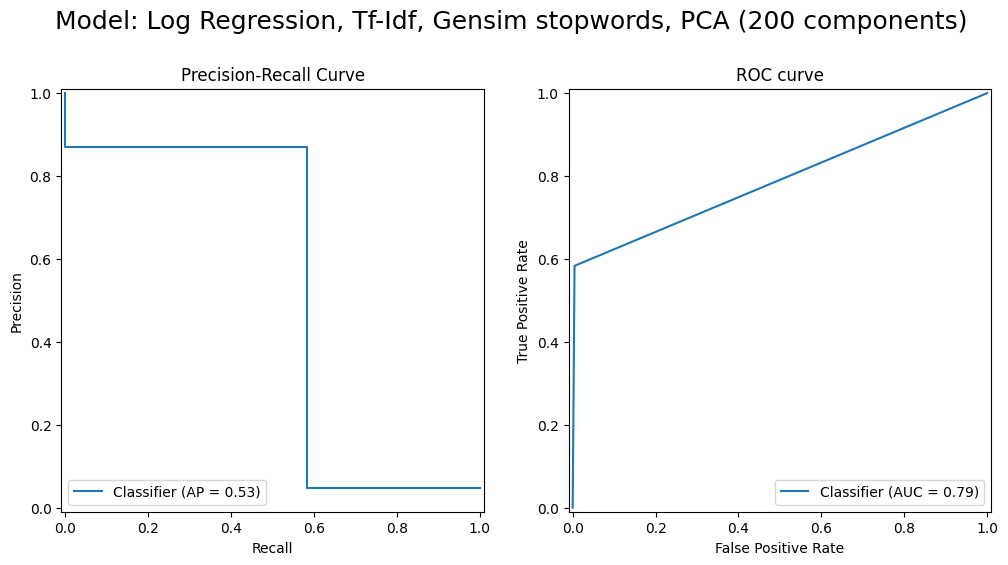

In [340]:
scores_log_tfidf_pca_stop, res_log_tfidf_pca_stop = evaluate_model(
    model_log_tfidf_pca_stop, X_test, y_test, 
    fig_subtitle= 'Log Regression, Tf-Idf, Gensim stopwords, PCA (200 components)', 
    short_name='log_tfidf_pca_stop', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [341]:
res_log_tfidf_pca_stop.to_csv('../data/results/res_log_tfidf_pca_stop.csv')

In [342]:
save_model(model_log_tfidf_pca_stop, 'model_log_tfidf_pca_stop')

In [343]:
scores_log_tfidf_pca_stop

{'model': 'log_tfidf_pca_stop',
 'accuracy': 0.9756152125279642,
 'precision': 0.8689655172413793,
 'recall': 0.5833333333333334,
 'f1_score': 0.6980609418282548,
 'roc_auc_score': 0.7894334743770569}

### PCA Summary

SUMMARY

In [345]:
pd.DataFrame([
    scores_base, scores_log_cv, scores_log_tfidf, scores_log_cv_pca, scores_log_cv_pca_200, 
    scores_log_cv_pca_300, scores_log_cv_pca_500, scores_log_cv_pca_stop, scores_log_cv_stop_gensim,
    scores_log_tfidf_pca, scores_log_tfidf_pca_200, scores_log_tfidf_pca_300, scores_log_tfidf_pca_500,
    scores_log_tfidf_pca_stop, scores_log_tfidf_stop_gensim
]).style.apply(
    highlight_max, props='color:white; background-color:darkblue', axis=0, 
    subset=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
)

Interestingly, in this application, we see that the best models so far are the Count Vectorizers with and without stop words.  Excluding stop words slightly improves accuracy and precision (and the F1-score), although the recall is better without stop words.  

Moving forward, I will use the logistic regression based on the Count Vectorizer.  I'm going to use the version without stop words.  The scores are very close, so I'm going to use the less complex model.

## Regularization

Based on the above, I will build my regularization models on the best model so far: the logistic regression with CountVectorizer and no stop words.  No PCA.

### Ridge Regularization

In [280]:
model_log_cv_ridge = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty='l2', C=0.1, max_iter= 500))
])

In [281]:
model_log_cv_ridge.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log', LogisticRegression(C=0.1, max_iter=500))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.96      0.71      0.82       216

    accuracy                           0.98      4470
   macro avg       0.97      0.85      0.90      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



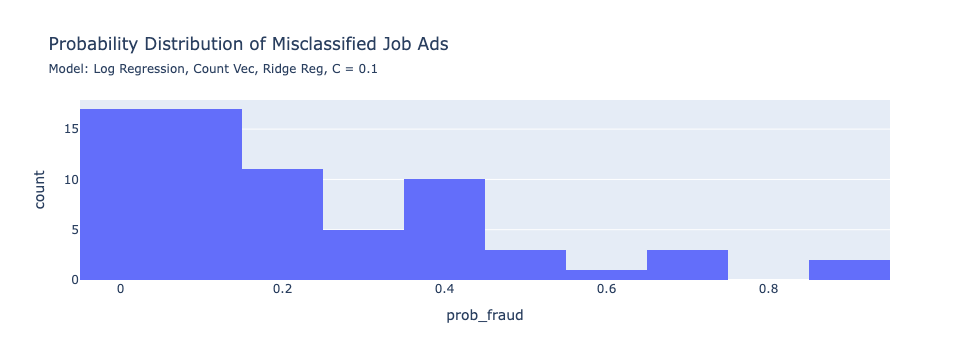

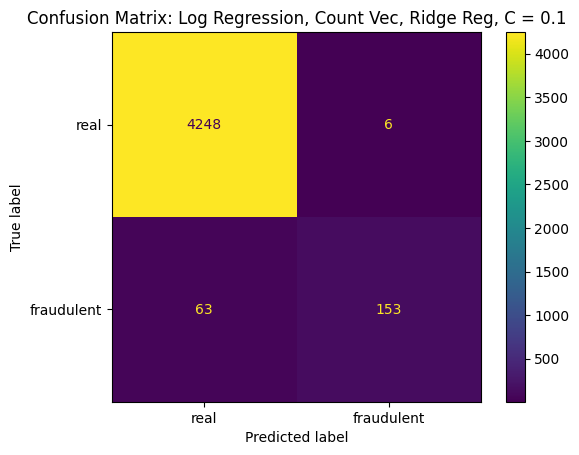

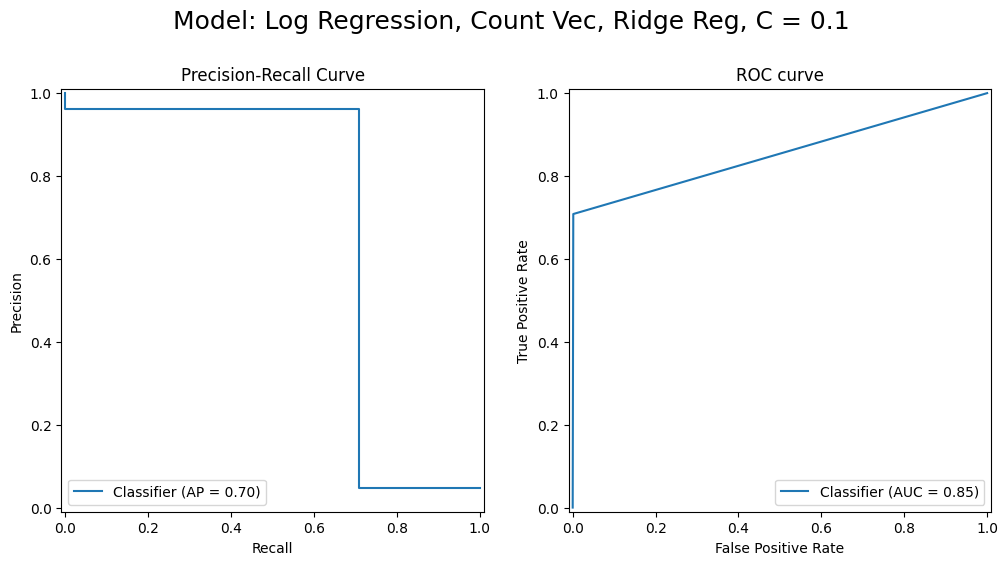

In [363]:
scores_log_cv_ridge, res_log_cv_ridge = evaluate_model(
    model_log_cv_ridge, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, Ridge Reg, C = 0.1', 
    short_name='log_cv_ridge', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [283]:
save_model(model_log_cv_ridge, 'model_log_cv_ridge')

In [284]:
res_log_cv_ridge.to_csv('../data/results/res_log_cv_ridge.csv')

In [285]:
scores_log_cv_ridge

{'model': 'log_cv_ridge',
 'accuracy': 0.9845637583892617,
 'precision': 0.9622641509433962,
 'recall': 0.7083333333333334,
 'f1_score': 0.816,
 'roc_auc_score': 0.8534614480488952}

#### Optimize Hyperparameters

In [361]:
ridge = GridSearchCV(
    model_log_cv_ridge, 
    param_grid={
        'ct__cv__stop_words': [None, 'english', stopwords_nltk, stopwords_spacy, stopwords_gensim],
        'log__C': [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.01,]
    },
    scoring='f1',
)

In [287]:
ridge.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('log',
                                        LogisticRegression(C=0.1,
                                                           max_iter=500))]),
             param_grid={'ct__cv__stop_words': [Non...
                                                 'with', 'had', 'sixty', 'this',
                                                 'keep', 'make', 'doing',
                                                 'full', 'himself', ...],
                                                ['bottom', 'their', 'ten',
                                                 'nowhere', 'whose', 'our',
                                                 'thereafter', 'hereupon',
                                                 'give', 'it', 'inc', 'than',
                                                 'of', 'where', 'up', 'first',
                                                 'may', 'nor', 'we', 'whenever',
                                                 'with', 'ltd', 'had', 'sixty',
                                                 'this', 'keep', 'make',
                                                 'doing', 'found', 'full', ...]],
                         'log__C': [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.01]},
             scoring='f1')

In [357]:
ridge.best_params_['log__C']

10

In [356]:
determine_stopword_list(ridge.best_params_['ct__cv__stop_words'])

'Gensim'

In [289]:
ridge.best_score_

0.828727012868506

In [366]:
ridge_2 = GridSearchCV(
    model_log_cv_ridge, 
    param_grid={
        'ct__cv__stop_words': [None, stopwords_gensim],
        'log__C': [10, 12, 15]
    },
    scoring='f1',
)

In [367]:
ridge_2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('log',
                                        LogisticRegression(C=0.1,
                                                           max_iter=500))]),
             param_grid={'ct__cv__stop_words': [None,
                                                ['bottom', 'their', 'ten',
                                                 'nowhere', 'whose', 'our',
                                                 'thereafter', 'hereupon',
                                                 'give', 'it', 'inc', 'than',
                                                 'of', 'where', 'up', 'first',
                                                 'may', 'nor', 'we', 'whenever',
                                                 'with', 'ltd', 'had', 'sixty',
                                                 'this', 'keep', 'make',
                                                 'doing', 'found', 'full', ...]],
                         'log__C': [10, 12, 15]},
             scoring='f1')

In [368]:
ridge_2.best_params_['log__C']

12

In [369]:
determine_stopword_list(ridge_2.best_params_['ct__cv__stop_words'])

'Gensim'


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.94      0.76      0.84       216

    accuracy                           0.99      4470
   macro avg       0.97      0.88      0.92      4470
weighted avg       0.99      0.99      0.99      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



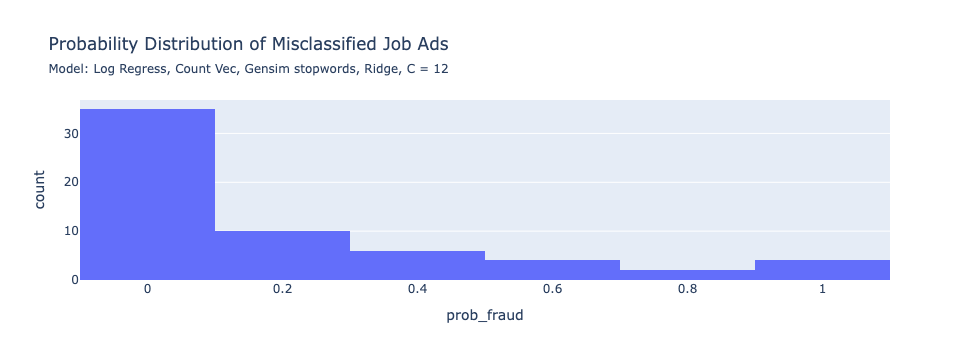

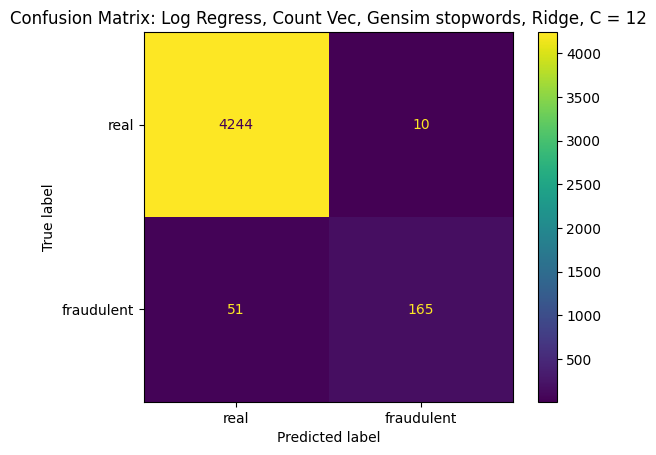

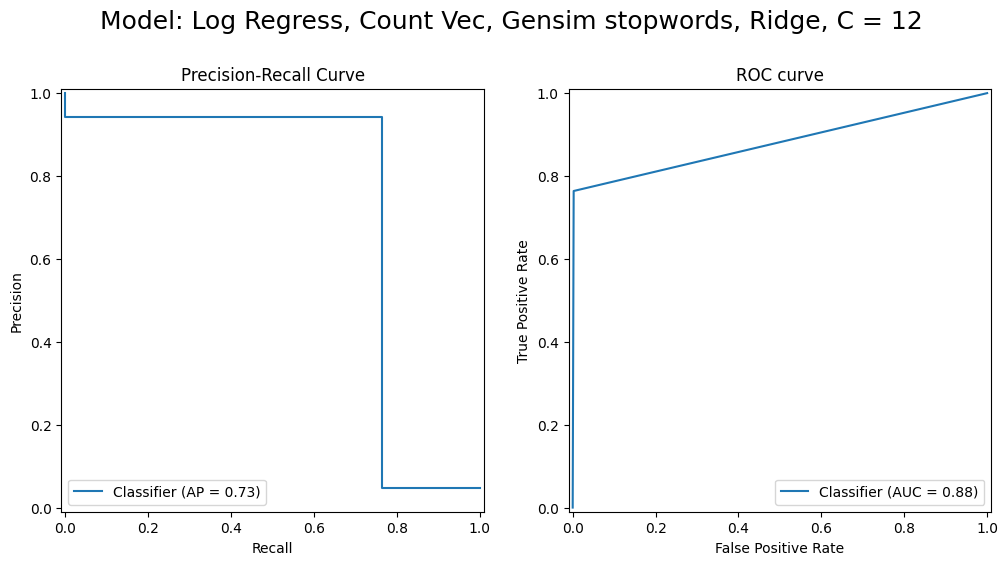

In [381]:
scores_log_cv_ridge_best, res_log_cv_ridge_best = evaluate_model(
    ridge_2, X_test, y_test, 
    fig_subtitle= 'Log Regress, Count Vec, Gensim stopwords, Ridge, C = 12', 
    short_name='log_ridge_best', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [382]:
save_model(ridge_2, 'model_ridge_best')

In [383]:
res_log_cv_ridge_best.to_csv('../data/results/res_log_cv_ridge_best.csv')

In [384]:
scores_log_cv_ridge_best

{'model': 'log_ridge_best',
 'accuracy': 0.9863534675615212,
 'precision': 0.9428571428571428,
 'recall': 0.7638888888888888,
 'f1_score': 0.8439897698209718,
 'roc_auc_score': 0.8807690800814919}

### LASSO Regularization

In [294]:
model_log_cv_lasso = Pipeline([
    ('ct', ColumnTransformer([
        ('cv', CountVectorizer(ngram_range=(1,2)), 'job_ad'),
        ('ohe', OneHotEncoder(drop='first'), ['employment_type', 'required_experience']),
    ], remainder= 'passthrough', force_int_remainder_cols=False)),
    ('log', LogisticRegression(penalty='l1', C=0.1, max_iter= 500, solver='liblinear'))
])

In [295]:
model_log_cv_lasso.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cv',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'job_ad'),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['employment_type',
                                                   'required_experience'])])),
                ('log',
                 LogisticRegression(C=0.1, max_iter=500, penalty='l1',
                                    solver='liblinear'))])


Classification Report: 

              precision    recall  f1-score   support

        real       0.98      1.00      0.99      4254
  fraudulent       0.90      0.58      0.71       216

    accuracy                           0.98      4470
   macro avg       0.94      0.79      0.85      4470
weighted avg       0.98      0.98      0.97      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



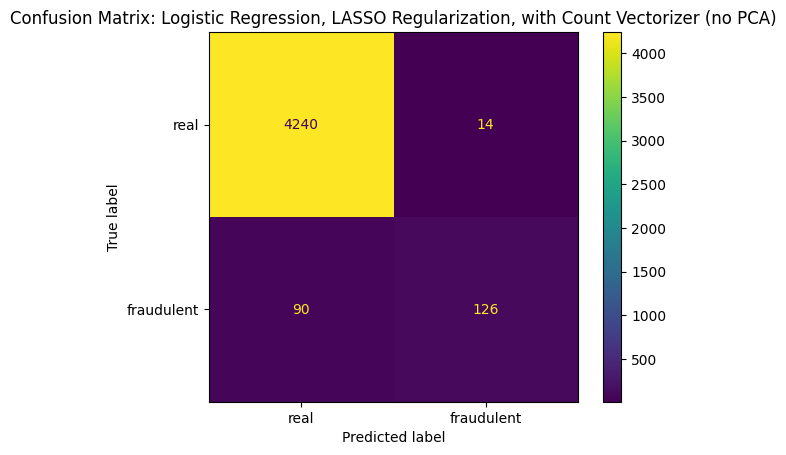

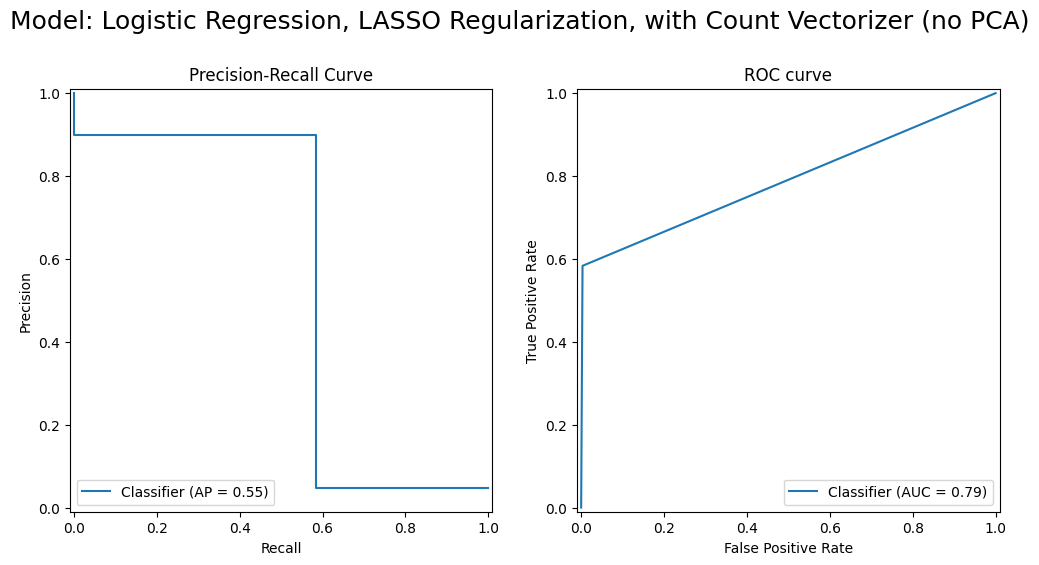

In [296]:
scores_log_cv_lasso, res_log_cv_lasso = evaluate_model(
    model_log_cv_lasso, X_test, y_test, 
    fig_subtitle= 'Logistic Regression, LASSO Regularization, with Count Vectorizer (no PCA)', 
    short_name='log_cv_lasso', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [297]:
save_model(model_log_cv_lasso, 'model_log_cv_lasso')

In [298]:
res_log_cv_lasso.to_csv('../data/results/res_log_cv_lasso.csv')

In [299]:
scores_log_cv_lasso

{'model': 'log_cv_lasso',
 'accuracy': 0.9767337807606264,
 'precision': 0.9,
 'recall': 0.5833333333333334,
 'f1_score': 0.7078651685393258,
 'roc_auc_score': 0.7900211565585332}

##### Optimize Hyperparameters

In [370]:
lasso = GridSearchCV(
    model_log_cv_lasso, 
    param_grid={
        'ct__cv__stop_words': [None, 'english', stopwords_nltk, stopwords_spacy, stopwords_gensim],
        'log__C': [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.01]
    },
    scoring= 'f1'
)

In [371]:
lasso.fit(X_train, y_train)

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.

/Users/erindepree/venvs/dsb_602/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('log',
                                        LogisticRegression(C=0.1, max_iter=500,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param...
                                                 'with', 'had', 'sixty', 'this',
                                                 'keep', 'make', 'doing',
                                                 'full', 'himself', ...],
                                                ['bottom', 'their', 'ten',
                                                 'nowhere', 'whose', 'our',
                                                 'thereafter', 'hereupon',
                                                 'give', 'it', 'inc', 'than',
                                                 'of', 'where', 'up', 'first',
                                                 'may', 'nor', 'we', 'whenever',
                                                 'with', 'ltd', 'had', 'sixty',
                                                 'this', 'keep', 'make',
                                                 'doing', 'found', 'full', ...]],
                         'log__C': [10, 5, 2, 1, 0.5, 0.1, 0.05, 0.01]},
             scoring='f1')

In [372]:
lasso.best_params_

{'ct__cv__stop_words': 'english', 'log__C': 10}

In [373]:
lasso.best_score_

0.8094801807668286

In [400]:
lasso2 = GridSearchCV(
    model_log_cv_lasso, 
    param_grid={
        'ct__cv__stop_words': [None, 'english', stopwords_gensim],
        'log__C': [14, 15, 20]
    },
    scoring= 'f1'
)

In [401]:
lasso2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cv',
                                                                         CountVectorizer(ngram_range=(1,
                                                                                                      2)),
                                                                         'job_ad'),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['employment_type',
                                                                          'required_experience'])])),
                                       ('log',
                                        LogisticRegression(C=0.1, max_iter=500,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             param_grid={'ct__cv__stop_words': [None, 'english',
                                                ['bottom', 'their', 'ten',
                                                 'nowhere', 'whose', 'our',
                                                 'thereafter', 'hereupon',
                                                 'give', 'it', 'inc', 'than',
                                                 'of', 'where', 'up', 'first',
                                                 'may', 'nor', 'we', 'whenever',
                                                 'with', 'ltd', 'had', 'sixty',
                                                 'this', 'keep', 'make',
                                                 'doing', 'found', 'full', ...]],
                         'log__C': [14, 15, 20]},
             scoring='f1')

In [402]:
lasso2.best_params_['log__C']

15

In [403]:
lasso2.best_params_

{'ct__cv__stop_words': 'english', 'log__C': 15}


Classification Report: 

              precision    recall  f1-score   support

        real       0.99      1.00      0.99      4254
  fraudulent       0.89      0.77      0.83       216

    accuracy                           0.98      4470
   macro avg       0.94      0.88      0.91      4470
weighted avg       0.98      0.98      0.98      4470



/var/folders/ty/qfl4p5vd2d3cxdrb54zzgq9w0000gn/T/ipykernel_96457/1519898396.py:43: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



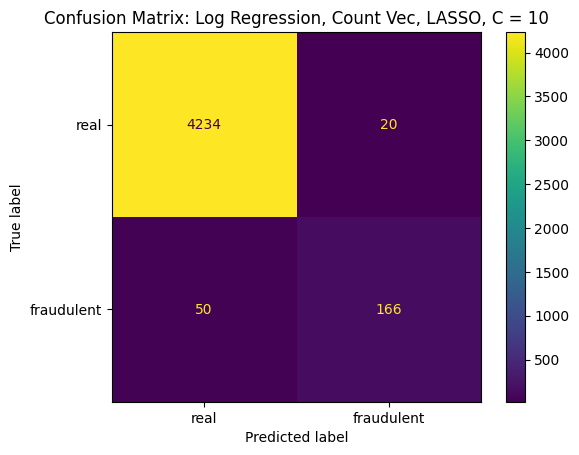

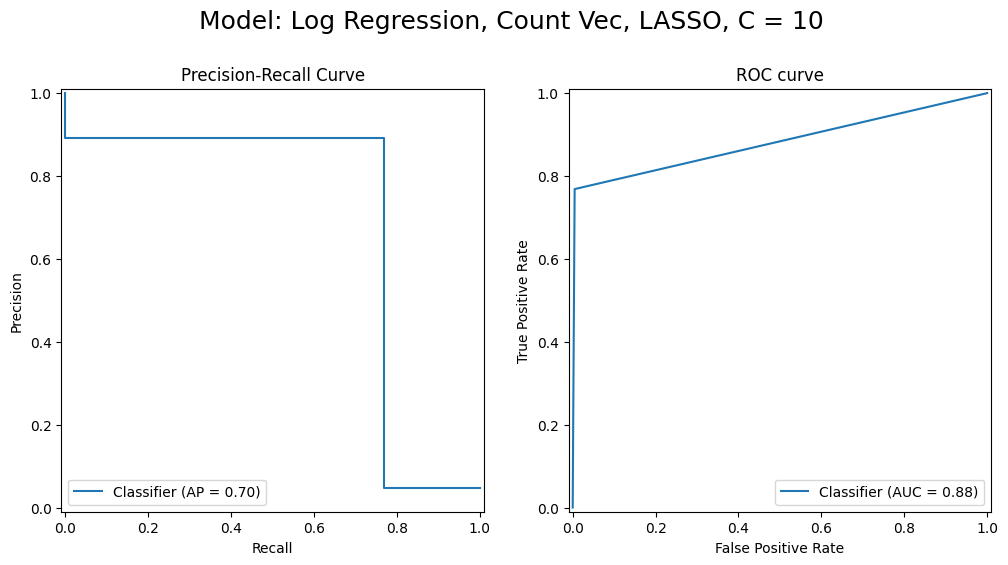

In [404]:
scores_log_cv_lasso_best, res_log_cv_lasso_best = evaluate_model(
    lasso2, X_test, y_test, 
    fig_subtitle= 'Log Regression, Count Vec, LASSO, C = 10', 
    short_name='log_lasso_best', 
    save_figs=True,
    return_misclassified = False,
    return_all_results = True
)

In [405]:
save_model(lasso2, 'model_lasso_best')

In [406]:
res_log_cv_lasso_best.to_csv('../data/results/res_log_cv_lasso_best.csv')

In [407]:
scores_log_cv_lasso_best

{'model': 'log_lasso_best',
 'accuracy': 0.9843400447427293,
 'precision': 0.8924731182795699,
 'recall': 0.7685185185185185,
 'f1_score': 0.8258706467661692,
 'roc_auc_score': 0.8819085305333543}

### Regularization Summary

In [408]:
pd.DataFrame([
    scores_base, scores_log_cv, scores_log_tfidf, scores_log_cv_stop_gensim,
    scores_log_cv_ridge, scores_log_cv_ridge_best,
    scores_log_cv_lasso, scores_log_cv_lasso_best,
]).style.apply(
    highlight_max, props='color:white; background-color:darkblue', axis=0, 
    subset=['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc_score']
)

## Summary

In [410]:
all_scores = [
    scores_base, scores_log_cv, scores_log_cv_stop_sklearn, 
    scores_log_cv_stop_nltk, scores_log_cv_stop_spacy, scores_log_cv_stop_gensim, 
    scores_log_tfidf, scores_log_tfidf_stop_sklearn, 
    scores_log_tfidf_stop_nltk, scores_log_tfidf_stop_spacy, scores_log_tfidf_stop_gensim,
    scores_log_cv_pca,
    scores_log_cv_pca_200,
    scores_log_cv_pca_300,
    scores_log_cv_pca_500,
    scores_log_cv_pca_stop,
    scores_log_tfidf_pca,
    scores_log_tfidf_pca_200,
    scores_log_tfidf_pca_300,
    scores_log_tfidf_pca_500,
    scores_log_tfidf_pca_stop,
    scores_log_cv_ridge,
    scores_log_cv_ridge_best,
    scores_log_cv_lasso,
    scores_log_cv_lasso_best,
]

In [411]:
all_scores_df = pd.DataFrame(all_scores)

In [412]:
all_scores_df.to_csv('./models/log_scores.csv', index=False)

In [413]:
all_scores_df.style.apply(highlight_max, props='color:white;background-color:darkblue', 
                          axis=0, subset=['accuracy','precision','recall', 'f1_score','roc_auc_score'])

So far, the Count Vectorizer has outperformed the Tf-Idf Vectorizer.  The best logistic regression probably includes a ridge regularization and a stop word list.  Although this best ridge regularization included using the Gensim stop word list.  We will come back to this in the [last notebook](4_summary.ipynb).  Next, let's explore more exotic models in [the next notebook](3_advanced_models.ipynb).